# Modelling of catalogue data
$\texttt{lenstronomy}$ was originally developed to simulate and model imaging data. The modular design allows to model and sample data in catalogue form too. In this notebook, we read in data from the Mahler et al. paper for multiple sources multiply imaged by a galaxy cluster.

In the first step, we read in the necessary data:
- lens parameters; including position and redshift
- image parameters; including positions, apparent magnitudes, 

and perform some calculations:
- each lensing galaxy's eccentricity, absolute magnitude, luminosity, distance, velocity dispersion, Einstein radius, and realtive mass
- relative time delays of images

The multiple images are then grouped together based on the number of sources and the known groups of multiple images.


In a second step, we use this data to sample the lens model parameter space. The modelling can also be used if only partial information is available (e.g. no time delays and/or flux ratio measurements) are available.

In a first step, we simulate a quad lens and compute the following mock data products:

- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties) based on a extended Gaussian surface brighness corresponding to a narrow line emission region.

In a second step, we use this mock data to sample the lens model parameter space (and optionally the quasar source size). The modelling can also be used if only partial information (e.g. no time delays and/or no flux ratio measurements) are available.

The notebook also describes the different possibilities in folding in the positional information in the modeling when the underlying requirement is that the images come from the same source and how to enforce this when evaluating the time delay prediction.

In [2]:
# import the necessary python modules
import astropy
import copy
import corner
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import time
import lenstronomy_clusters_functions.clusters_functions
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from lenstronomy.Util import param_util
from lenstronomy.Plots import lens_plot
from lenstronomy.PointSource.point_source import PointSource
import lenstronomy_clusters_functions.clusters_functions

%matplotlib inline

## Reading in catalogue data

In [3]:
# important initial values

random.seed(10)
measurement_realization = True  # if True, draws measurement values from the uncertainties, if not, keeps the true value

In [4]:
# mini functions to check if something is a float or not, and to find the value of a float before the decimal point (rounding down)
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def find_value_before_decimal(list, target_value):
    count = 0
    for decimal in list:
        decimal = float(decimal)
        if math.floor(decimal) == target_value:
            count += 1
    return count

In [5]:
# READING IN AND CONVERTING DATA - LENS PARAMETERS

# reading in the data, just a mess because the file is not normalized
with open('input.par', 'r') as input:
    params = []
    for line in input:
        if line.find(":") != -1 or line.find(" ") != -1:
            if line.find(":") != -1:
                name, value = line.split(":")
            if line.find('\t') != -1:
                line = line.replace('\t', " ")
                line = line.lstrip()
                line = line.rstrip()
            if line.count(" ") >= 2:
                name, value = line.split(" ", 1)
                name = name.strip()
                value = value.lstrip()
                value = value.rstrip()
                value = value.split(" ")
                for x in value:
                    if is_float(x) is True:
                        x = float(x)
                    else:
                        x = x
            else:
                name, value = line.split(" ")
                if line.find(":") != -1:
                    name = name.replace(":", " ")
                name = name.strip()
                value = value.lstrip()
                value = value.rstrip()
                if is_float(value) is True:
                    value = float(value)
            params.append([name, value])
        elif line.find(" ") == -1:
            line = line.lstrip()
            line = line.rstrip()
            params.append(line)
input.close()

input_data_frame = pd.DataFrame(params, columns=["Variable", "Value", "", "", "", "", "", "", "", ""])

reference_point = [float(input_data_frame['Value'].iloc[9][1]), float(input_data_frame['Value'].iloc[9][2])]
# [110.82675, -73.454628] from the Mahler paper

In [6]:
# reading in the data from the Mahler galaxy catalog. Formatting is aweful, so a lot of data normalization. Then we get out data on each cluster member's:
    # Galaxy ID, RA, DEC, a, b, theta, apparent magnitude, z. The ra and dec are converted form degrees to arcsec. a and b are used to calculate the ellipticity

with open('galcat.cat', 'r') as file:
    gal_cat = file.read()

lines = gal_cat.splitlines()

for i in range(len(lines)):
    lines[i]=lines[i].lstrip('#')
    lines[i]=lines[i].lstrip(str(chr(32)))

gal_data=[]
for i in range(len(lines)):
    gal_data.append(lines[i].split(' '))

# We don't need blank lines, so find them...
str_to_find = ''
Is = []
for i in range(len(gal_data)):
    blank_in_data = np.isin(str_to_find, gal_data[i])
    if blank_in_data == True:
        Is.append(i)
Is.reverse()
# ... and now get rid of them
for i in range(len(Is)):
    row_to_remove = Is[i]
    gal_data.remove(gal_data[row_to_remove])
# Convert the position from deg to arcsec
gal_data_deg = copy.deepcopy(gal_data)

# convert values from strings to floats
for i in range(len(gal_data_deg)):
    for j in range(len(gal_data_deg[i])):
        gal_data_deg[i][j] = float(gal_data[i][j])

# subtract reference point from galaxy positions in degrees
for i in range(len(gal_data_deg)):
    gal_data_deg[i][1] = (gal_data_deg[i][1] - reference_point[0])*math.cos(reference_point[1])
    gal_data_deg[i][2] = (gal_data_deg[i][2] - reference_point[1])

gal_data_corr = copy.deepcopy(gal_data_deg)

# convert coordinates to arcsec
for i in range(len(gal_data_corr)):
    gal_data_corr[i][1] = gal_data_deg[i][1]*3600
    gal_data_corr[i][2] = gal_data_deg[i][2]*3600

# make data frame
columns = ['Galaxy ID', 'RA', 'DEC', 'a', 'b', 'theta', 'magnitude', 'z']

gal_data_arcsec = pd.DataFrame(gal_data_corr, columns=columns)
print(len(gal_data_arcsec))

# the Mahler data has the redshift listed as 0.0 for each of the cluster members relative to the main lens mass. For this code, we need the individual member redshifts
# so we will assume each of them to be 0.39, like the lens mass. This is most likely to simple of an assumption, but for now it will have to do.

z_cluster_members = []
for i in range(len(gal_data_arcsec)):
    z_cluster_members.append(0.39)

148


In [7]:
## load in the new image data and convert to make it useable
# this reads in the Mahler data on the multiple image systems. Each arc is then sorted, and the refernce ra and dec are recorded in arcsec.
    # The image redshifts are input by hand as listed in the Mahler paper.

#process for data in a .dat file with ' ' as delimiter
with open('arcs.dat', 'r') as file:
    arcs_data = file.read()
lines = arcs_data.splitlines()
arcs_data_deg=[]
for i in range(len(lines)):
    arcs_data_deg.append(lines[i].split(' '))

arcs_data_corr = copy.deepcopy(arcs_data_deg)       # deepcopy ensures there are no rounding errors

for i in range(len(arcs_data_corr)):
    for j in range(len(arcs_data_deg[i])-1):
        arcs_data_corr[i][j] = float(arcs_data_deg[i][j])

for i in range(len(arcs_data_corr)):
    arcs_data_corr[i][1] = (arcs_data_corr[i][1] - reference_point[0])*math.cos(reference_point[1])
    arcs_data_corr[i][2] = arcs_data_corr[i][2] - reference_point[1]

arcs_data_arcsec = copy.deepcopy(arcs_data_corr)

# convert to arcsec
for i in range(len(arcs_data_arcsec)):
    arcs_data_arcsec[i][1] = arcs_data_corr[i][1]*3600
    arcs_data_arcsec[i][2] = arcs_data_corr[i][2]*3600

ra_list = []
dec_list = []
for i in range(len(arcs_data_deg)):
    ra_list.append(arcs_data_deg[i][1])
    dec_list.append(arcs_data_deg[i][2])

x_pos_list = []
y_pos_list = []
for i in range(len(arcs_data_arcsec)):
    x_pos_list.append(arcs_data_arcsec[i][1])
    y_pos_list.append(arcs_data_arcsec[i][2])

# create a list of image ids
num_images=len(arcs_data_arcsec)
image_ids = []
for i in range(num_images):
    image_ids.append(str(arcs_data_arcsec[i][0]))

## caluculate number of sources from image list
num_images_list = []
sources_list = []
for i in range(len(arcs_data_arcsec)):
    index = find_value_before_decimal(image_ids, i+1)
    if index != 0:
        num_images_list.append(index)
        sources_list.append(i+1)
print(num_images_list)
total_images = sum(num_images_list)
num_sources_data = len(sources_list)

# z for the images from the Mahler paper. In the future, would want to read these in, but not listed in the data set
z_sources_new = [1.449, 1.449, 1.449, 1.3779, 1.3779, 1.3779, 1.9914, 1.9914, 1.9914, 1.9914,
                 2.31, 2.31, 2.31, 1.425, 1.425, 1.425, 1.70, 1.70, 1.70, 5.17, 5.17, 5.17, 
                 14.39, 14.39, 3.01, 3.01, 1.43, 1.43, 1.43, 1.73, 1.73, 1.73, 1.81, 1.81, 
                 1.81, 3.34, 3.34, 3.34, 2.04, 2.04, 2.04, 1.09, 1.09, 2.12, 2.12, 2.12, 1.37, 
                 1.37, 1.37, 1.37, 1.37, 1.37, 2.60, 2.60, 2.60, 3.93, 3.93, 3.93, 2.88, 2.88]

[3, 3, 4, 3, 3, 3, 3, 2, 2, 3, 2, 3, 4, 3, 2, 3, 3, 3, 3, 3, 2]


In [8]:
# Image properties
# this groups the images according to the sources that they came from, each list contains lists of the associated image ID's, positions, and redshifts. Used for plotting purposes.

grouped_ids = []
grouped_x_imgs = []
grouped_y_imgs = []
grouped_z_sources = []

cutoff = 0
for i in range(num_sources_data):
    ids_temp = []
    images_x_temp = []
    images_y_temp = []
    z_temp = []
    for j in range(num_images_list[i]):
        ids_temp.append(image_ids[j+cutoff])
        images_x_temp.append(x_pos_list[j+cutoff])
        images_y_temp.append(y_pos_list[j+cutoff])
        z_temp.append(z_sources_new[j+cutoff])
    cutoff += num_images_list[i]
    grouped_ids.append(ids_temp)
    grouped_x_imgs.append(images_x_temp)
    grouped_y_imgs.append(images_y_temp)
    grouped_z_sources.append(z_temp)

In [9]:
# Input for lens properties
# This includes the assumed cosmology, the lens parameters for each dPIED member galaxy, and the NFW dark matter halo

import astropy.units as u

z_lens = float(input_data_frame['Value'].iloc[50][0])

# source properties
z_source_convention= 1.5

v_disp = float(input_data_frame['Value'].iloc[68][0])
Ra = float(input_data_frame['Value'].iloc[66][0])
Rs = float(input_data_frame['Value'].iloc[67][0])

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.) # H_0 {km/s/Mpc}, omega_0 (= (ρ / ρ_critical) where ρ is the actual density of the universe and ρ_critical is the critical density), Omega_b (Baryon density today)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source_convention)

# for the astropy calculation of the luminosity distances or the cluster member galaxies
astro_cosmo = FlatLambdaCDM(H0=70*u.km / u.s / u.Mpc, Tcmb0=2.725*u.K, Om0=0.3)

# make class instances for a chosen lens model type. Chose a lens model
lens_model_list = []
for i in range(len(gal_data_arcsec)):
    lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL')
lens_model_list.append('NFW_ELLIPSE_CSE')

# make instance of LensModel class. Only one here, the shifting of the sources will happen in the computing bit further down in this block
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source_convention=z_source_convention, z_source=z_sources_new[0])

# we require routines accessible in the LensModelExtensions class, then make instance of LensEquationSolver to solve the lens equation
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

In [10]:
phi = 0.1
gamma = 0.1
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.1)
# chose the data where the lens is centered at (0,0)

# calculate the eccentricities in a way that matches lenstronomy's definitions
angle_rads=[]
qs = []
eccentricities = []
e1s = []
e2s = []
for i in range(len(gal_data_arcsec)):
    angle_rad = (gal_data_arcsec['theta'].iloc[i])*(math.pi/180)        # 'theta' is defined as: ellipticity of the matter density
    q = ((gal_data_arcsec['b'].iloc[i])/(gal_data_arcsec['a'].iloc[i]))
    ecc = (1-q)/(1+q)
    e1 = float(ecc * (math.cos(2*angle_rad)) * 0.5)
    e2 = float(ecc * (math.sin(2*angle_rad)) * 0.5)

    angle_rads.append(angle_rad)
    qs.append(q)
    eccentricities.append(ecc)
    e1s.append(e1)
    e2s.append(e2)

nfw_angle_rad = (float(input_data_frame['Value'].iloc[65][0]))*(math.pi/180)  # now based on the 'angle_pos' value, not the 'theta' value. Is there something similar for the member galaxies?
nfw_q = float(input_data_frame['Value'].iloc[64][0])
nfw_ecc = (1-nfw_q)/(1+nfw_q)
nfw_e1 = float(nfw_ecc * (math.cos(2*nfw_angle_rad)) * 0.5)
nfw_e2 = float(nfw_ecc * (math.sin(2*nfw_angle_rad)) * 0.5)    # check the orientation

print('q: %s, ecc: %s, e1: %s, e2: %s' %(nfw_q, nfw_ecc, nfw_e1, nfw_e2))

# 'theta' is definied as from the horizontal (E) upwards towards N by Mahler
# 'angle_pos': Set the position angle of the potential distribution expressed in degree (90° relative to PA). It corresponds to the direction of the semi-major axis of the iso-potential counted from the horizontal axis, counterclockwise.

# units_coordinates_parameter_definitions.ipynb

q: 0.161, ecc: 0.7226528854435831, e1: 0.18932996344052383, e2: 0.307751463284245


In [11]:
# kwargs_lens

kwargs_lens = []

# Calculating the mass-luminosity scaling. # the paper cited by Mahler sets alpha = -1.25 and L_star = 3*10**10 L_sun. # L_sun =  3.8 x 10**26 watts = 3.8 x 10**33 ergs/sec = 10**26 joules/sec
grav = (scipy.constants.G)  * 10**(-9)                       # m**3/(kg*s**2), gravitational constant

Rt_star = 6.171*10**20      # m, 20 now, 30 kpc = 9.257*10**20 m, truncation radius of a typical, mily way-type galaxy
Rt_star_kpc = 20

ms = gal_data_arcsec['magnitude']   # apparent magniudes of the lenses
M_sun = 4.83                # absolute magnitude of the sun
M_mw = -20.6
M_andromeda = -21.5         # approximate

L_sun = 3.8*10**26          # watts, luminosity of the sun    = 3.8*10**33 ergs/sec = 10**26 joules/sec
L_mw = float(L_sun * 10**(0.4*(M_sun-M_mw)))  # this equation works!
L_andromeda = (2.6*10**10)*L_sun
L_star = 3*10**10 * L_sun   # watts, luminosity of a typical, milky way-type galaxy

L_ratio_star = L_star/L_mw
L_ratio_andromeda = L_andromeda/L_mw
L_ratios = []

sigma_v_star = 160          # km/s, central Velocity Dispersion of a typical, milky way-type galaxy
mass_star = 6*(10**42)      # kg, mass of a milky way type galaxy
alpha = 0.7                 # tunes the size of the galaxy halo

D_l_andromeda = 765000
D_l_Mpcs = []               # luminosity distance in Mpc
D_l_pcs = []                # luminosity distance in pc

Ms = []
Ls = []                     # watts, luminosity of the galaxy

sie_sigma_vs = []
sie_theta_Es = []
dPIED_sigma_0s = []

for i in range(len(gal_data_arcsec)):
    D_l_Mpc = astro_cosmo.luminosity_distance(z_cluster_members[i])   # this is in units of MPC
    D_l_Mpcs.append(D_l_Mpc)
    D_l_pc = float(D_l_Mpc / u.Mpc * (10**6))               # convert to pc for the absolute magnitude calculation
    D_l_pcs.append(D_l_pc)                                  # --> *(3.086*(10**19)) to m
    M = float(ms.iloc[i] - 5*(math.log(D_l_pc, 10)) + 5)    # this gives M around -23
    Ms.append(M)
    # convert magnitude to luminosity, use Milky Way as a reference:
    L = float(L_mw * 10**(0.4*(M_mw-Ms[i])))                # L = L_sun * 10**((M_sun-Mags.iloc[i])/2.5) # L = L_sun * 10**((4.83-M[i])/2.5)
    Ls.append(L)
    L_ratio = float(L/L_mw)
    sie_sigma_v = float(sigma_v_star * (Ls[i]/L_star)**(0.25) - 65)  # km/s # check these values in literature
    sie_theta_E = float(lensCosmo.sis_sigma_v2theta_E(sie_sigma_v))  # arcsec
    dPIED_sigma_0 = float(lensCosmo.vel_disp_dPIED_sigma0(vel_disp=sie_sigma_v, Ra=float(gal_data_arcsec['a'].iloc[i]), Rs=Rt_star_kpc))   ## Ra is the core radius, Rs is the truncation radius
    L_ratios.append(L_ratio)
    sie_sigma_vs.append(sie_sigma_v)
    sie_theta_Es.append(sie_theta_E)
    dPIED_sigma_0s.append(dPIED_sigma_0)

print('z cluster members: %s, \nD_l_Mpc: %s, \nD_l_pc: %s' %(z_cluster_members, D_l_Mpcs, D_l_pcs))
# print('Apparent m: %s' %(ms))
print('Absolute M: %s' %(Ms))
print('Luminosities: %s' %(Ls))
print('L ratios to MW: %s' %(L_ratios))
print('sigma_vs: %s, \ntheta_es: %s' %(sie_sigma_vs, sie_theta_Es))
print('sigma0: %s' %(dPIED_sigma_0s))


# solve for the mass scaling
masses = [] # milky way-masses, masses of each member galaxy
massV2 = []
mw_mass = 1.5*10**12 # solar masses, mass of the milky way
Ts = []

for i in range(len(gal_data_arcsec)):
    mL_scaling_relationship = ((1/grav))*((sigma_v_star)**2)*(Rt_star*(Ls[i]/L_star)**(0.5 + alpha)) ## Natarajan & Kneib 1997
    T = 12 * (sigma_v_star/240)**2 * (Rt_star_kpc/30) * (Ls[i]/L_star)**(alpha - 0.5)
    Ts.append(T)
    masses.append(mL_scaling_relationship)    # closer to kg, mass of the given galaxy
print('Mass: %s' %(masses))
print('ML ratio: %s' %(Ts))

nfw_mass = 10**14.5 # solar masses, mass of a galaxy cluster's halo
concentration = 10  # ratio of r200 to Rs
nfw_Rs, nfw_alpha_Rs = lensCosmo.nfw_physical2angle(nfw_mass, concentration) # outputs Rs angle and alpha Rs. See google slides 1/27/25
nfw_sigma_v = float(input_data_frame['Value'].iloc[68][0])

for i in range(len(gal_data_arcsec)):
    kwargs_lens.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})
kwargs_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})

# Definitions:
# dPIED
    # :param sigma0: sigma0/sigma_crit (see class documentation above)
    # :param Ra: core radius (see class documentation above)
    # :param Rs: transition radius from logarithmic slope -2 to -4 (see class documentation)
    # :param e1: eccentricity component in x-direction
    # :param e2: eccentricity component in y-direction
    # :param center_x: center of profile
    # :param center_y: center of profile

# NFW:
#     :param Rs: turn over point in the slope of the NFW profile in angular units. transition radius from 1 to 3 power law (arcsec), alpha Rs is the defelction angle at that radius
#     :param alpha_Rs: deflection (angular units) at projected Rs
    # :param e1: eccentricity component in x-direction
    # :param e2: eccentricity component in y-direction
#     :param center_x: center of halo (in angular units)
#     :param center_y: center of halo (in angular units)

z cluster members: [0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39], 
D_l_Mpc: [<Quantity 2108.19904034 Mpc>, <Quantity 2108.19904034 Mpc>, <Quantity 2108.19904

In [12]:
# use image positions and calculate their (finite) magnifications
mag_infs = []
source_sizes_pc = []
source_sizes_arcsec = []
mag_finites = []
t_days = []

D_s = lensCosmo.ds      # angular distance
print(D_s)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

for i in range(num_sources_data):
    lensEquationSolver.change_source_redshift(z_source=z_sources_new[i])  # here is where we change the redshift

    mag_inf_temp = lensModel.magnification(grouped_x_imgs[i], grouped_y_imgs[i], kwargs_lens)
    mag_infs.append(mag_inf_temp)

    source_size_pc_temp = random.randrange(0, 15)
    source_sizes_pc.append(source_size_pc_temp)
    source_size_arcsec_temp = source_sizes_pc[i] / 10**6 / D_s / constants.arcsec
    source_sizes_arcsec.append(source_size_arcsec_temp)

    mag_finite_temp = lensModelExtensions.magnification_finite(x_pos=grouped_x_imgs[i], y_pos=grouped_y_imgs[i], kwargs_lens=kwargs_lens, source_sigma=source_sizes_arcsec[i], window_size=window_size, grid_number=grid_number)
    mag_finites.append(mag_finite_temp)
    
    t_days_temp = lensModel.arrival_time(grouped_x_imgs[i], grouped_y_imgs[i], kwargs_lens)
    t_days.append(t_days_temp)

print(mag_infs)
print(t_days)

1745.5423064934434


c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  c = amp / (2 * np.pi * sigma**2)
c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:44: RuntimeWarning: divide by zero encountered in divide
  r2 = (x - center_x) ** 2 / sigma**2 + (y - center_y) ** 2 / sigma**2
c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:45: RuntimeWarning: invalid value encountered in multiply
  return c * np.exp(-r2 / 2.0)


[array([ 1.98891721,  4.93536115, 13.84352671]), array([ 2.09858551, 15.91176934, 12.69724677]), array([ 1.80554653, -1.96410895,  2.97762908, -3.49515513]), array([1.64573712, 2.31313979, 2.8462957 ]), array([-35.48778263,  -3.01950196,   1.9166883 ]), array([2.83093494, 4.88877889, 2.26162297]), array([2.35900051, 2.59853969, 2.35977133]), array([1.45555229, 1.85051153]), array([1.67005666, 2.21255467]), array([-11.07364365,  -2.24485747,   2.12733231]), array([2.69565261, 3.25178494]), array([ 3.24187653, -6.12549647,  2.23578473]), array([ 2.19571471, -1.95194492,  1.88092818, -3.33815332]), array([2.62132969, 5.42949685, 1.8326404 ]), array([-2.75115231, -2.60345971]), array([  6.26576933, -17.57426341,   1.6005778 ]), array([ 8.96707984, -3.36302719,  2.24106462]), array([14.19938805, -3.37449116,  2.18960392]), array([2.82904457, 4.41184604, 1.69699327]), array([2.84166569, 4.34377022, 2.59260218]), array([1.54615232, 1.58781874])]
[array([-100747.94602301,  -97842.19357678,  -9

## Add plots here to compare to the Mahler paper
We then plot the convergence (or mass distribution), critical curves and caustics, and the image positions. This uses three key word arguments from the lens_model_plot function, and produces a plot using that and the point_source_plot function. The three key arguments are:
- with_convergence=True: for the first plot, this creates the map of the mass distribution based on the lens model parameters that have been input.
- with_caustics=True: for the second plot, this shows the critical curves in red and the caustics in green. Critical curves represent a line of positions where the lens will infinitely magnify a source, and the caustics represent where the images formed by that critical curve would appear on the image plane.
- images_from_data=True: for the third plot, the places a diamond at each point an image appears from the input ps kwargs and scales the diamond according to the calculated magnifications.

Below that are rows of plots. These are grouped by each source's set of multiple images and show what our model predicts each image would look like according to its position and hte lens mass distribution.

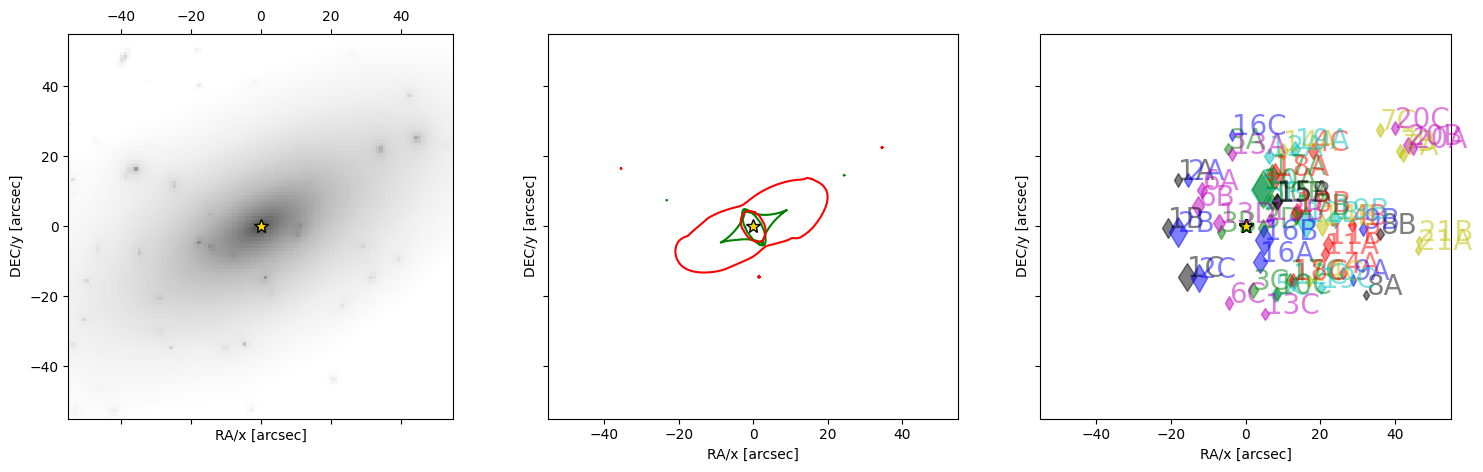

In [13]:
# Create figure and axes
f, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

#Name_list = None  is the default, replace none with a list of strings (ex below) to have custom labels
Name_list = [[".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10"], ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]] # if using a custom Name_list, insert:  name_list=Name_list[i]  into the list of parameters for plotting.
num_Names = len(Name_list)
color_list = ['k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y'] # should be at least as long as the number of sources


# Define ellipse parameters
gals = []
for i in range(len(gal_data_arcsec)):                                                                                                                           # angle in degrees
    gals.append({"xy":(gal_data_arcsec['RA'].iloc[i], gal_data_arcsec['DEC'].iloc[i]), "width":gal_data_arcsec['a'].iloc[i], "height":gal_data_arcsec['b'].iloc[i], "angle":gal_data_arcsec['theta'].iloc[i]})

lensModel.change_source_redshift(z_source=grouped_z_sources[0][0])
lens_plot.lens_model_plot(ax[0], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
                              mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[1], point_source=True,
                              images_from_data=False, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=True,
                              fontsize=5
                            )

rgba_transparent = (1.0, 1.0, 1.0, 0.0)
lens_plot.lens_model_plot(ax[1], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=[], images_y=[],
                              mag_images=None, index=0, color_value=color_list[0], name_list=Name_list[1], point_source=True,
                              images_from_data=False, with_caustics=True, numPix=110, deltaPix=1.0, with_convergence=False,
                              fontsize=5
                            )
for i in range(num_sources_data):
        lens_plot.lens_model_plot(ax[2], lensModel=lensModel, kwargs_lens=kwargs_lens, images_x=grouped_x_imgs[i], images_y=grouped_y_imgs[i], 
                              mag_images=None, index=i, color_value=color_list[i], name_list=Name_list[1], point_source=True,
                              images_from_data=True, with_caustics=False, numPix=110, deltaPix=1.0, with_convergence=False,
                              fontsize=5
                            )
# Show the plot
plt.show()

# kappa = lens.kappa(x_grid_rot, y_grid_rot, kwargs_lens)

C:\Users\earth\AppData\Local\Temp\ipykernel_4420\707012058.py:38: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')


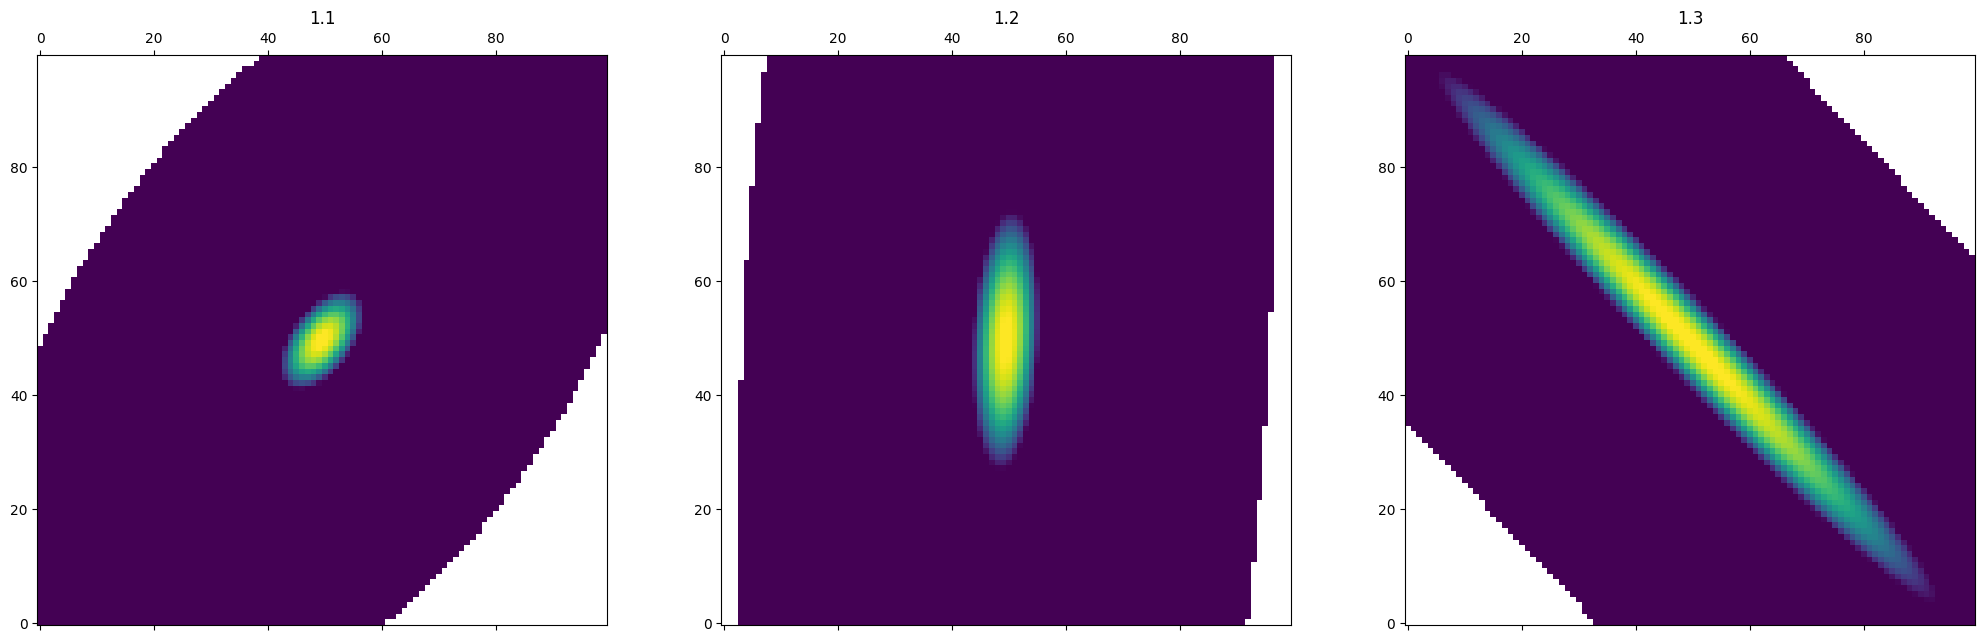

c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  c = amp / (2 * np.pi * sigma**2)
c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:44: RuntimeWarning: divide by zero encountered in divide
  r2 = (x - center_x) ** 2 / sigma**2 + (y - center_y) ** 2 / sigma**2
c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\LightModel\Profiles\gaussian.py:45: RuntimeWarning: invalid value encountered in multiply
  return c * np.exp(-r2 / 2.0)


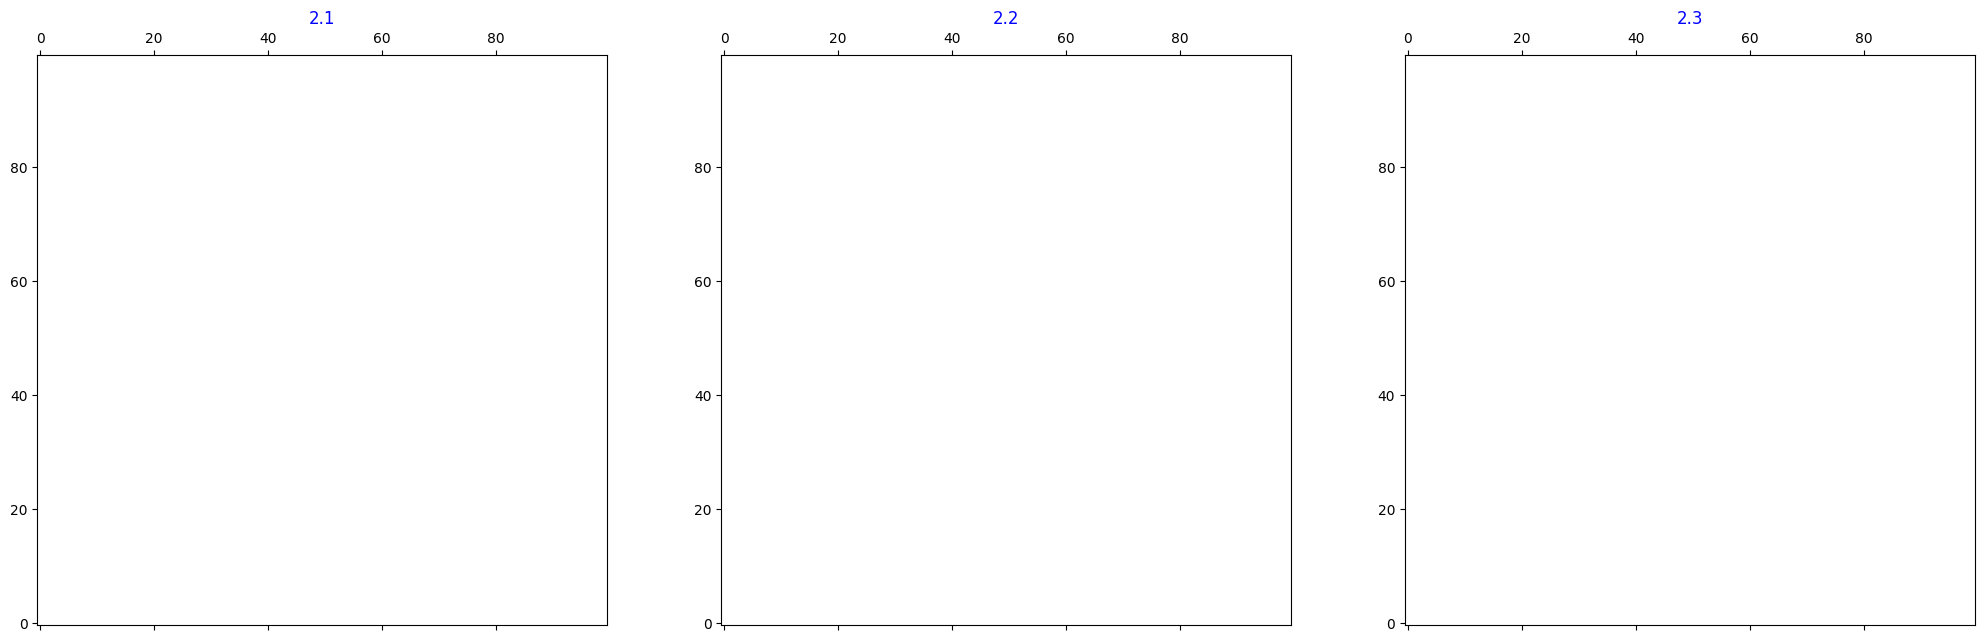

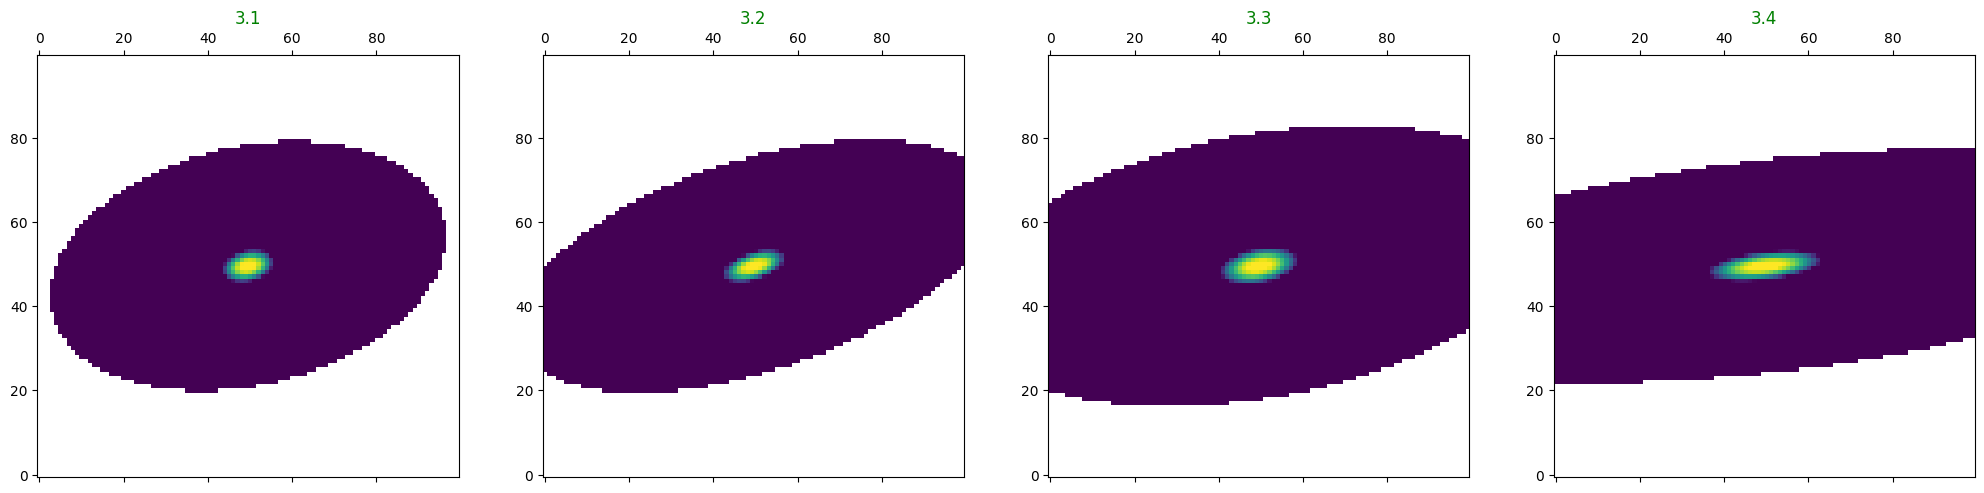

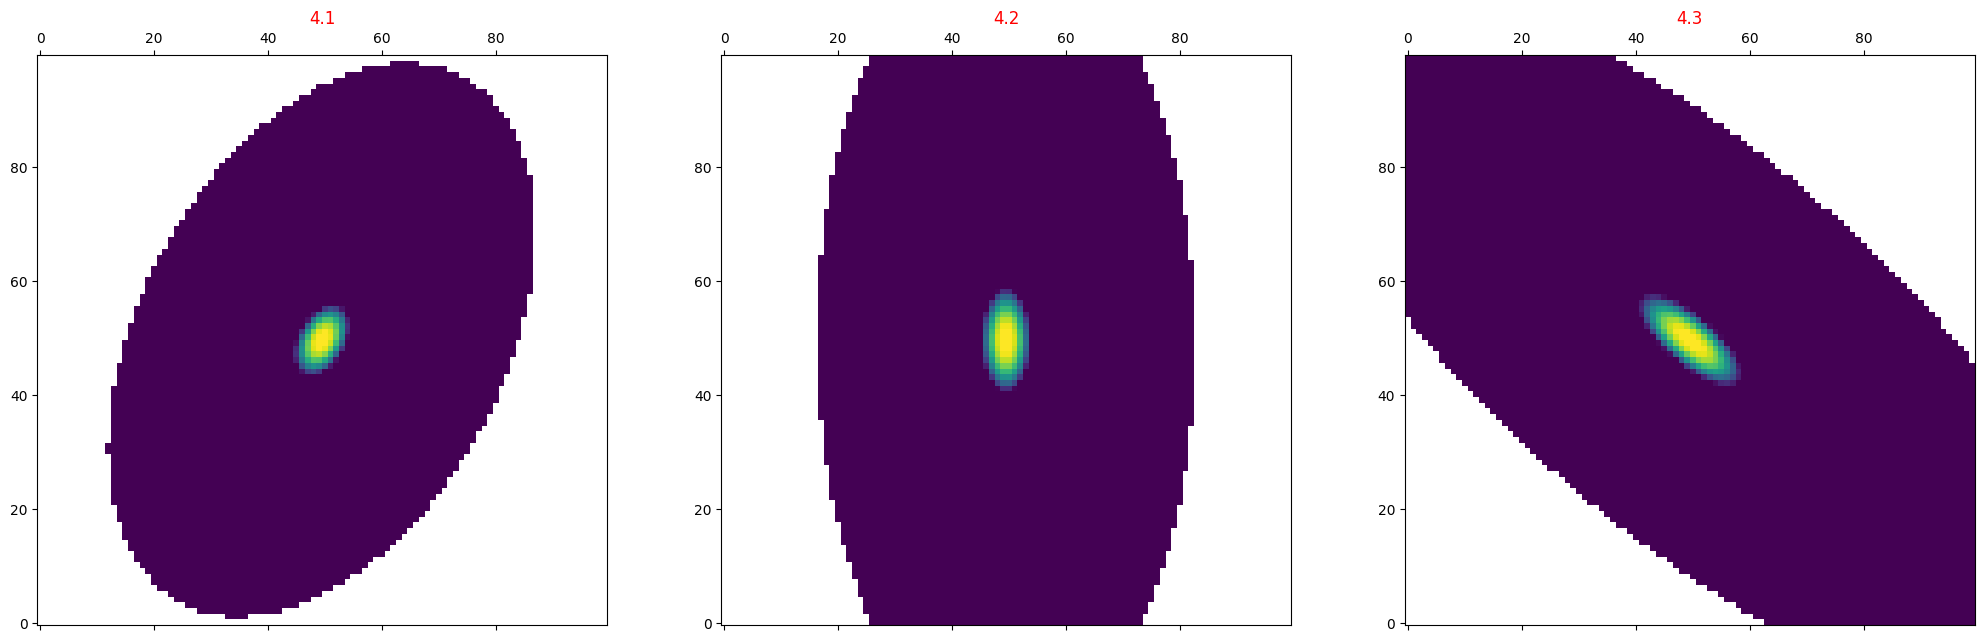

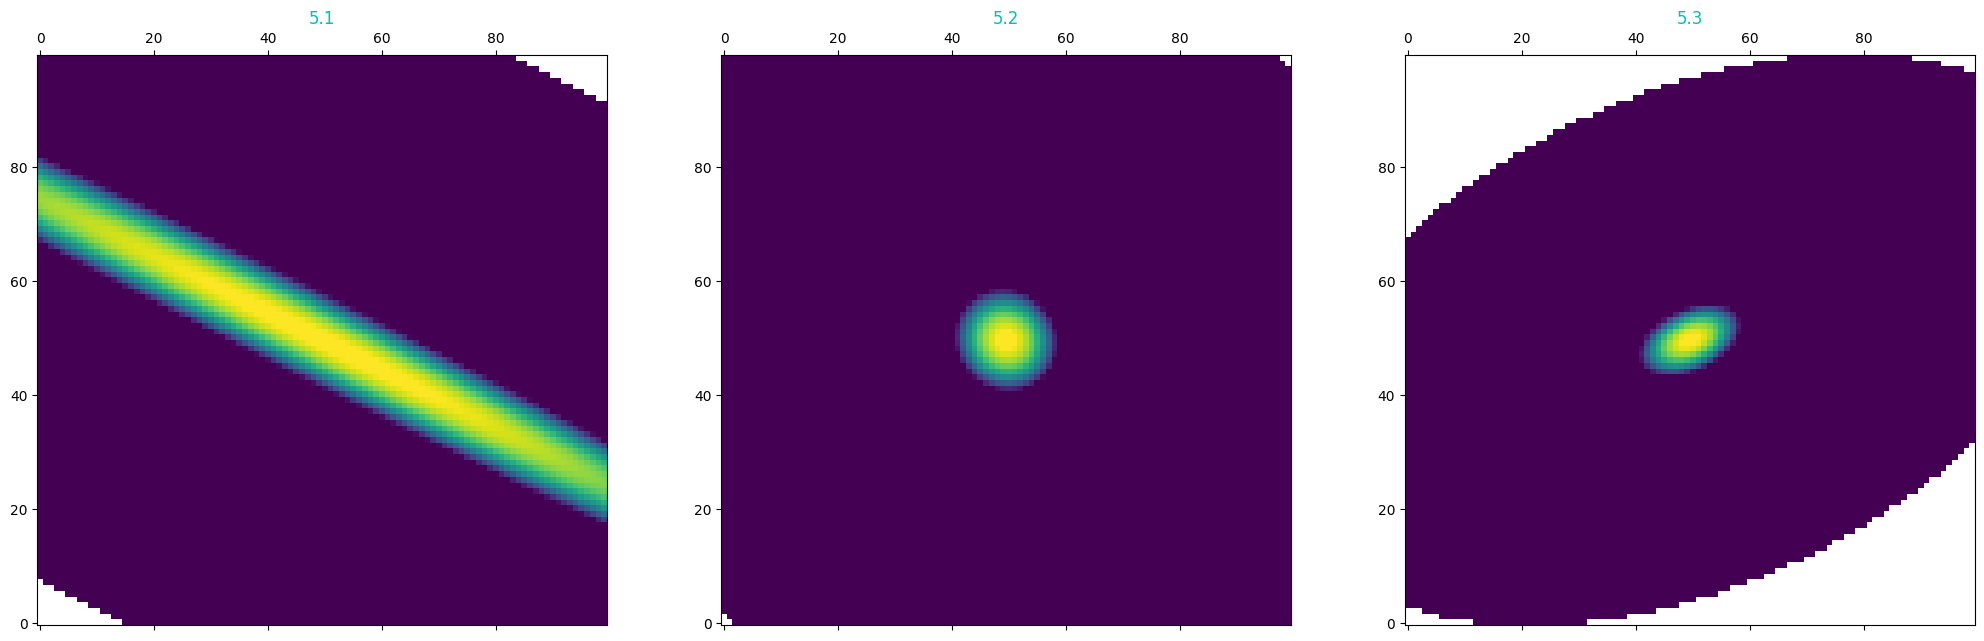

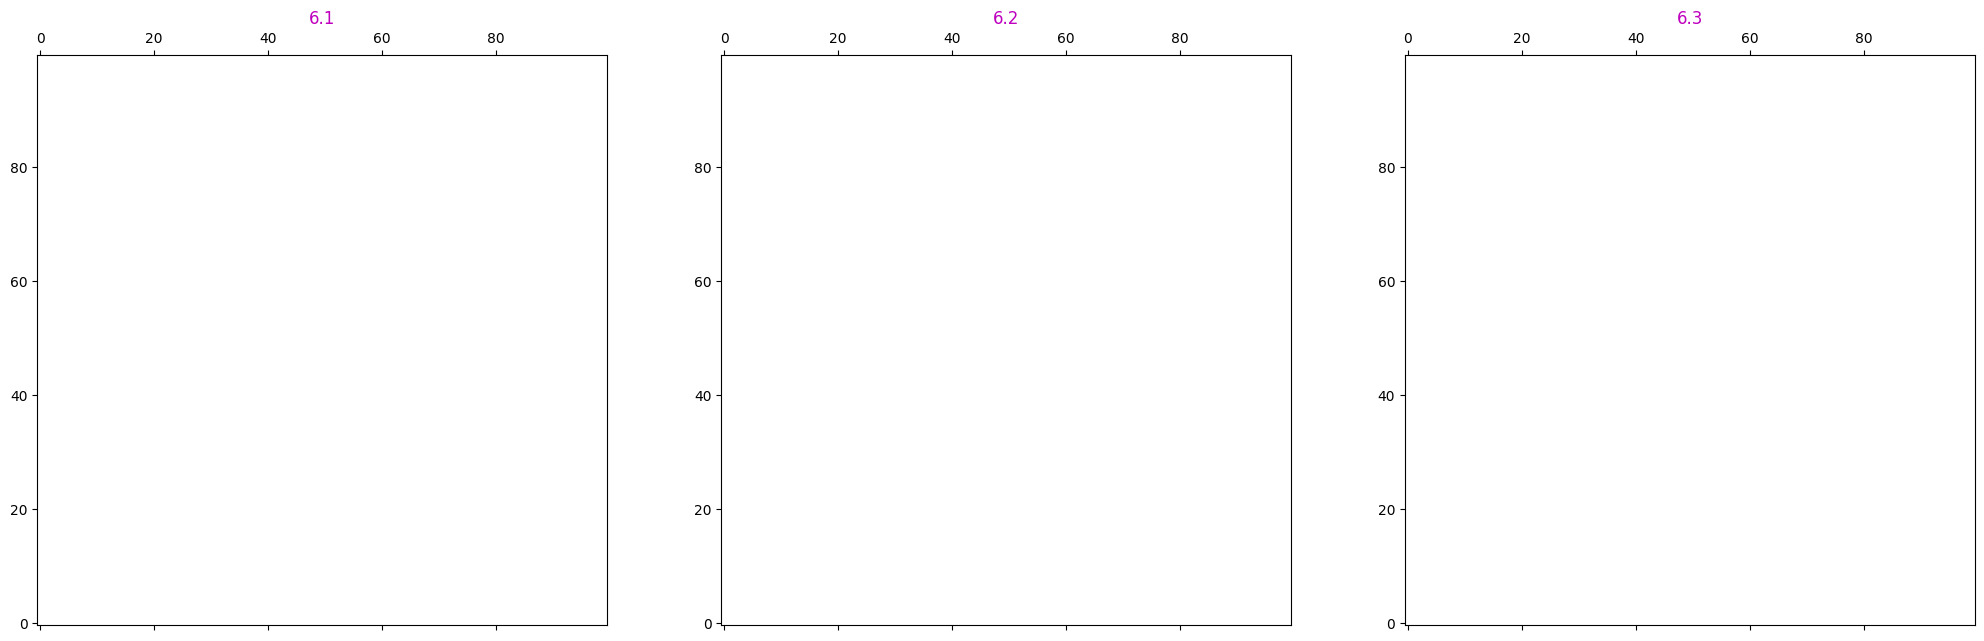

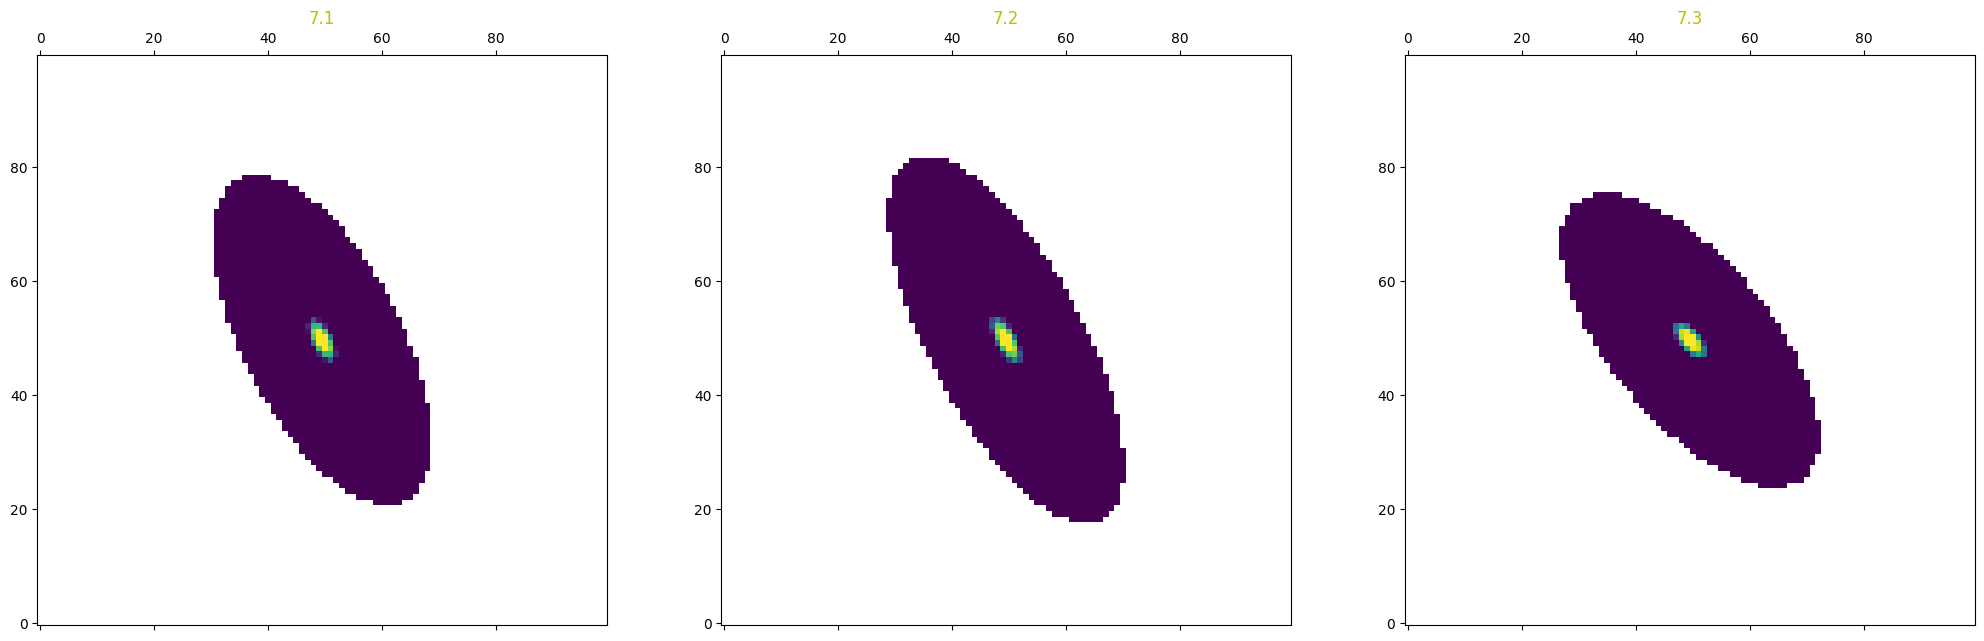

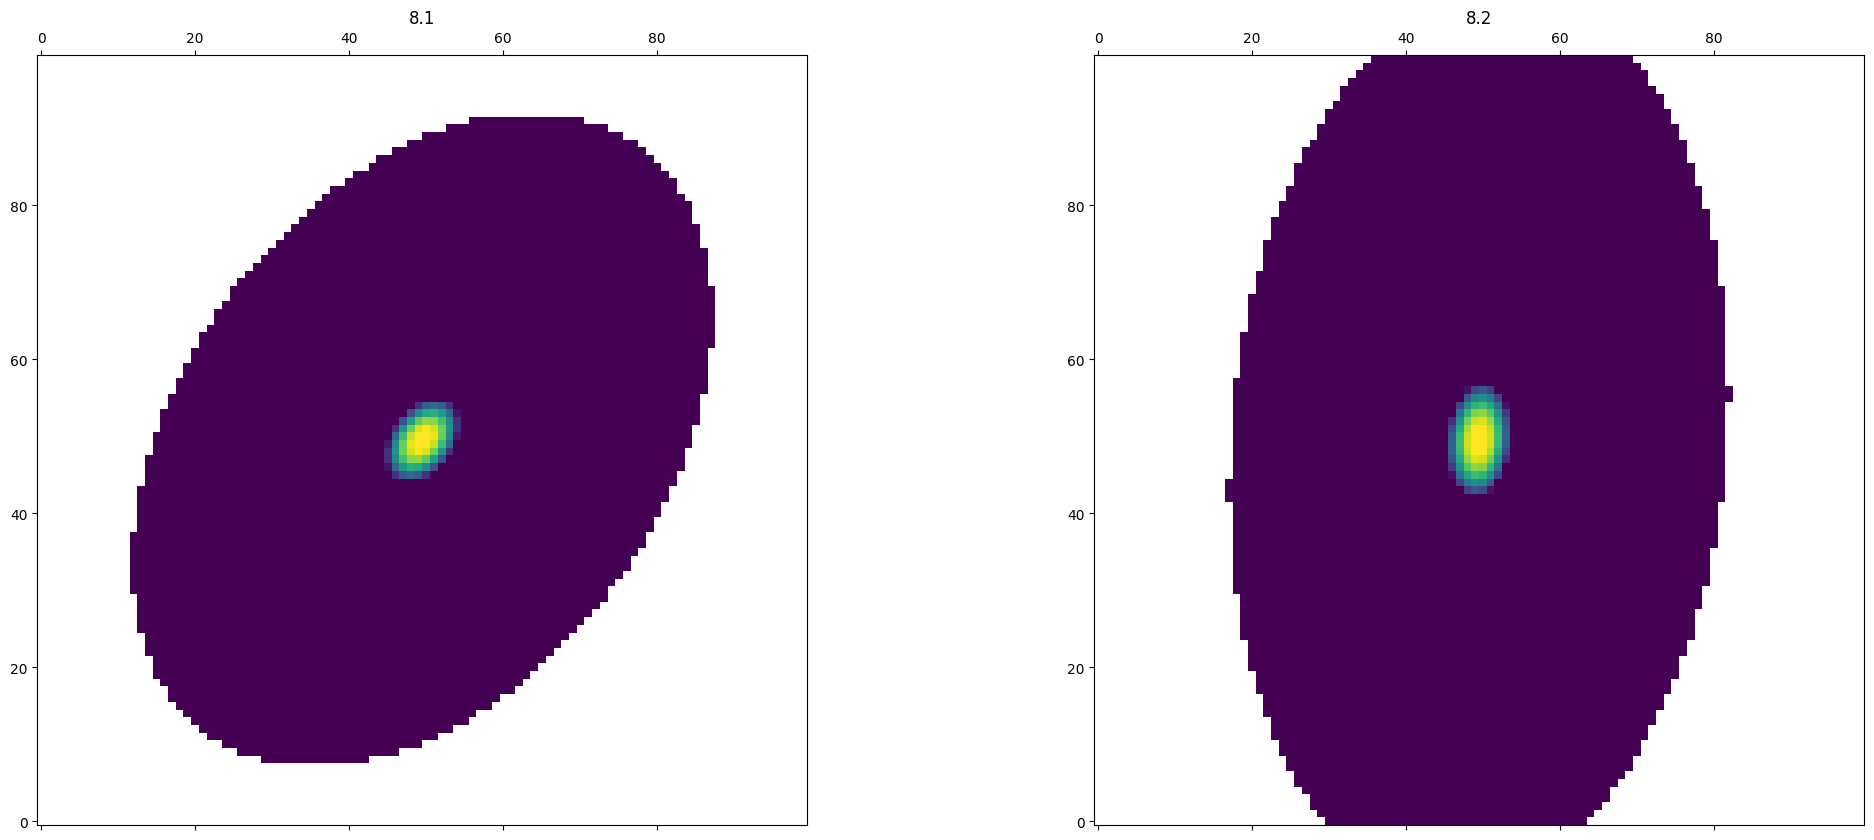

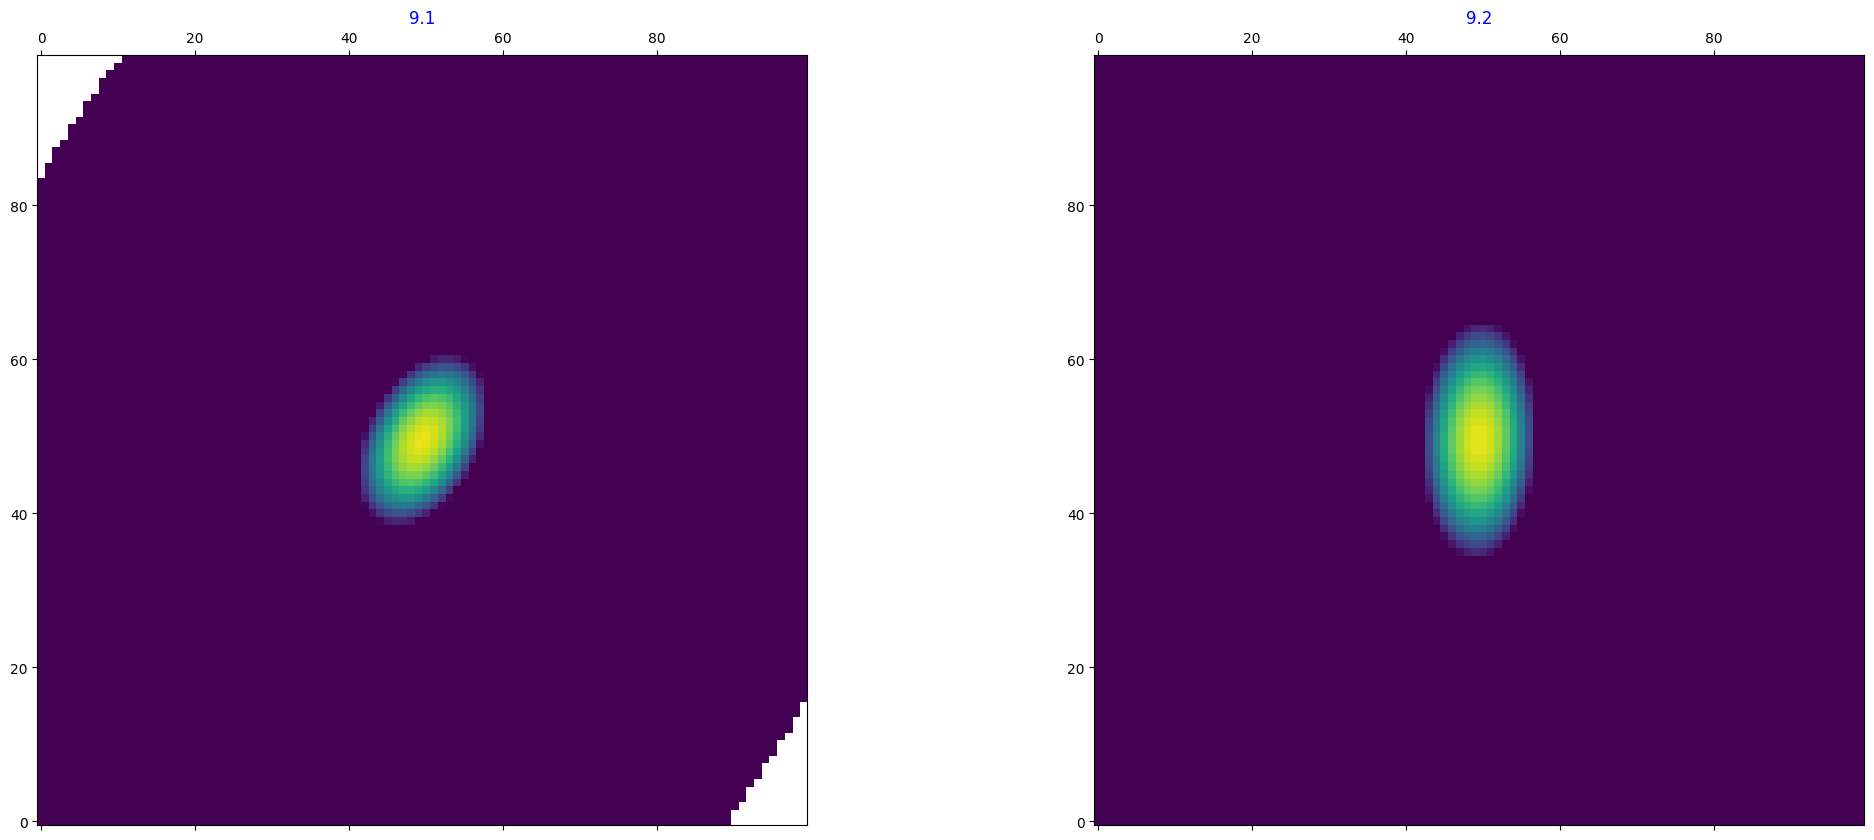

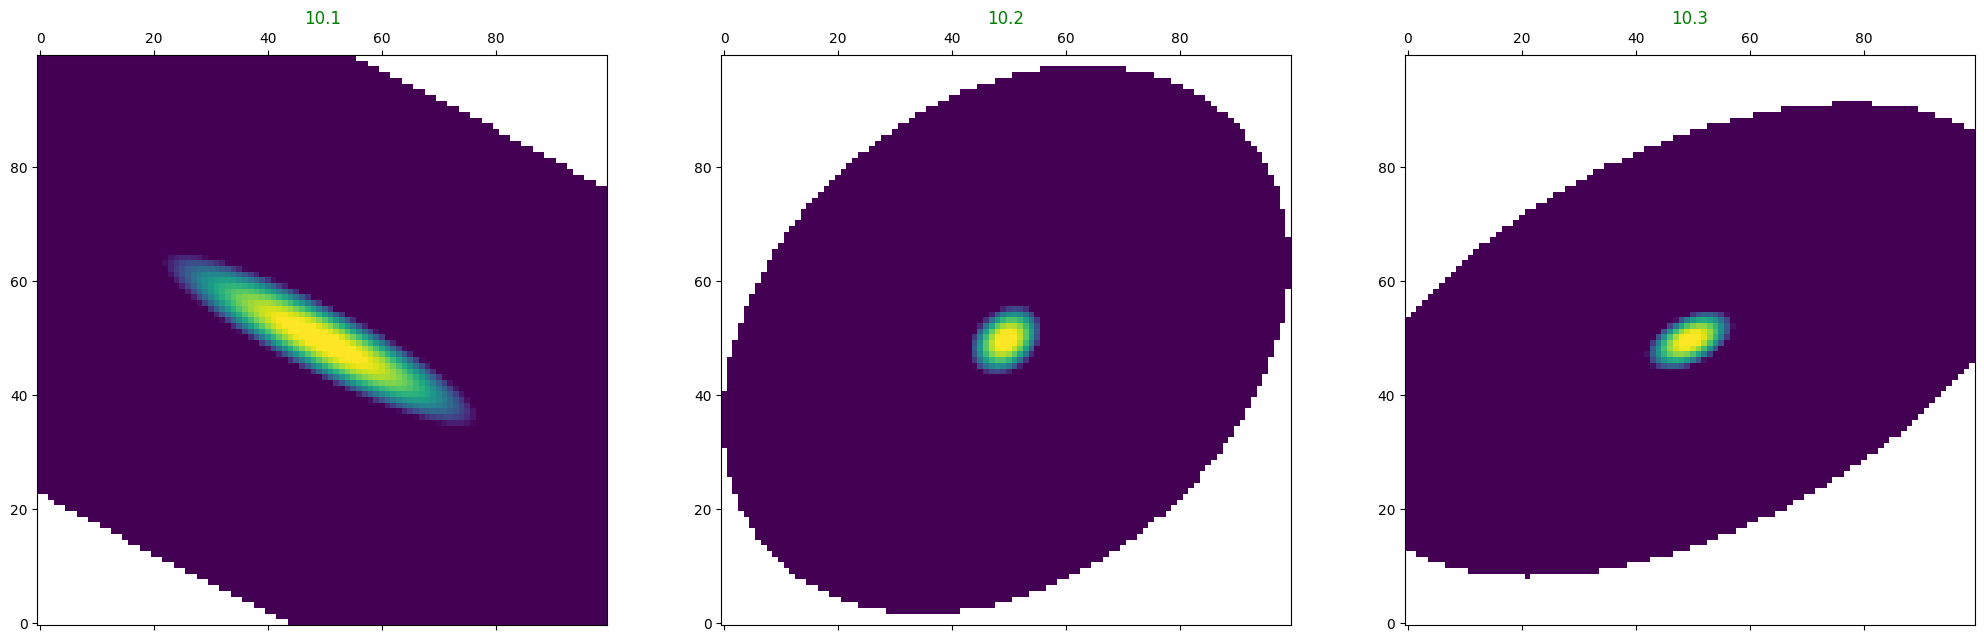

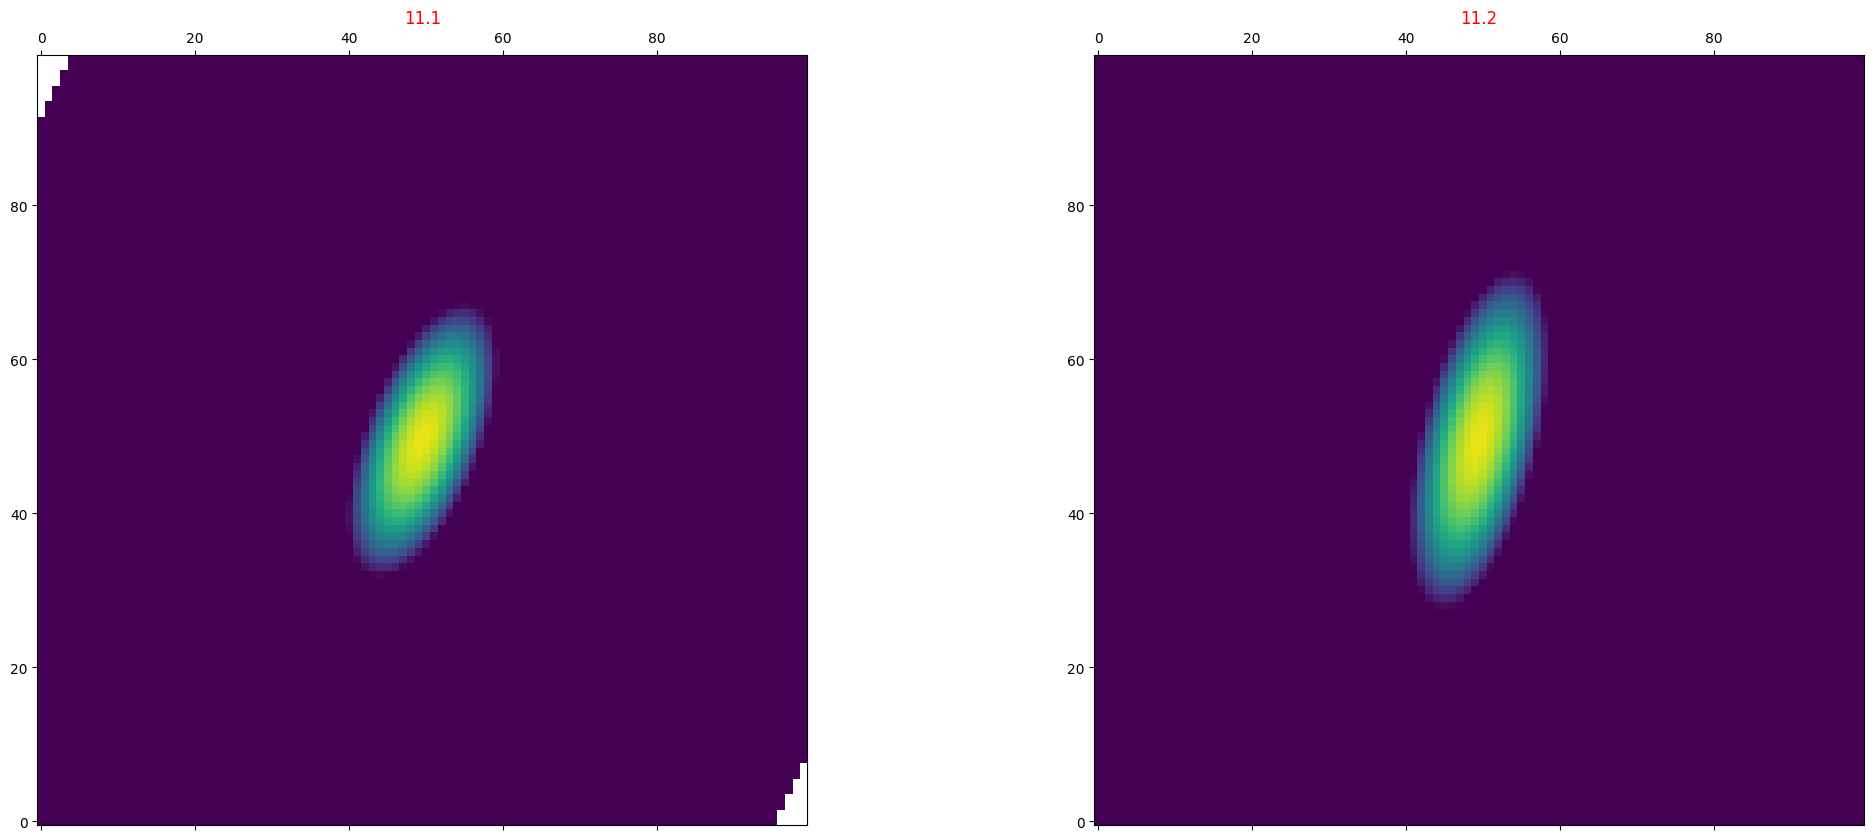

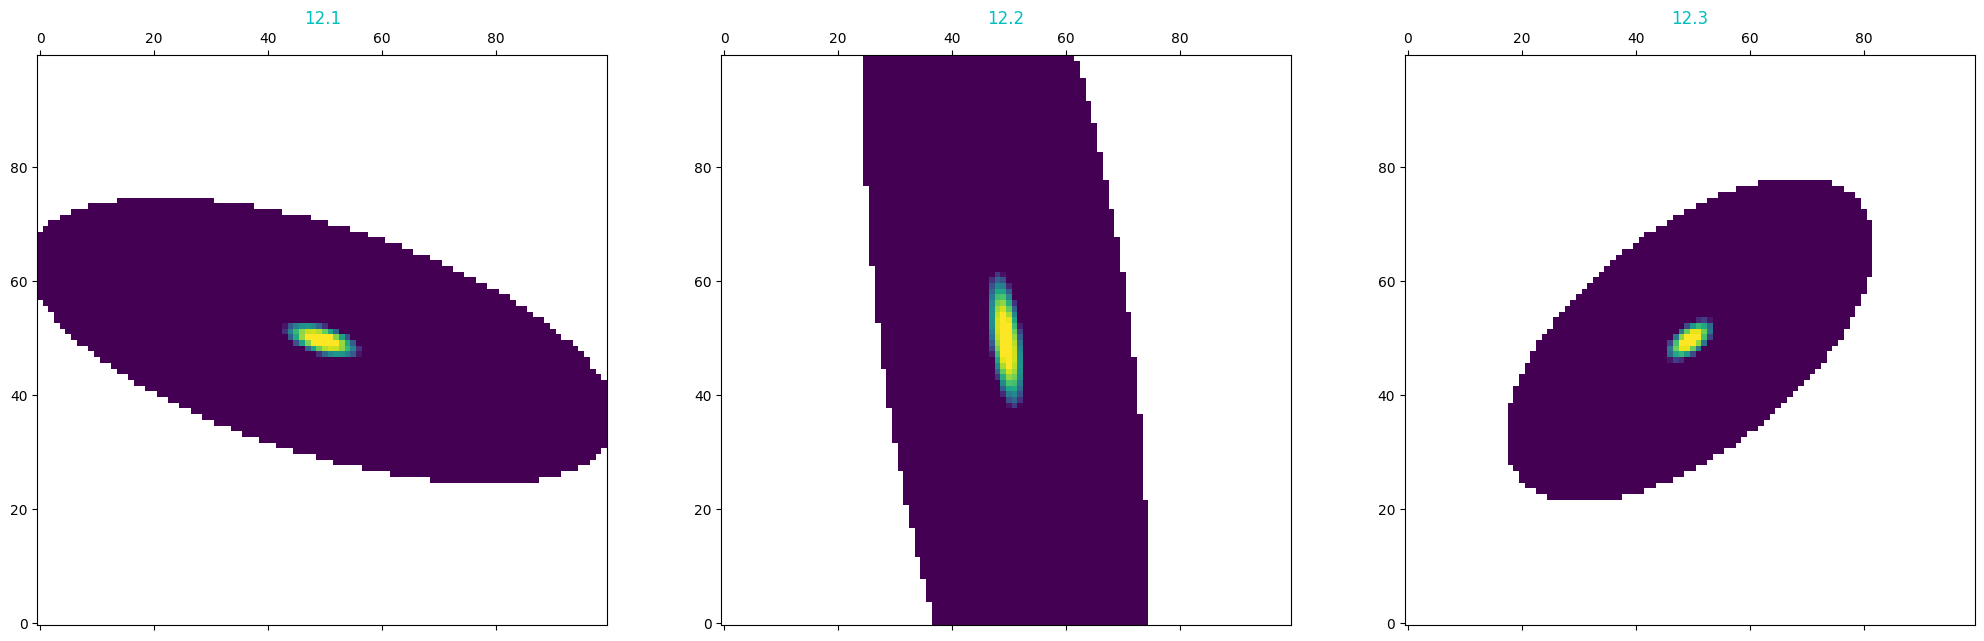

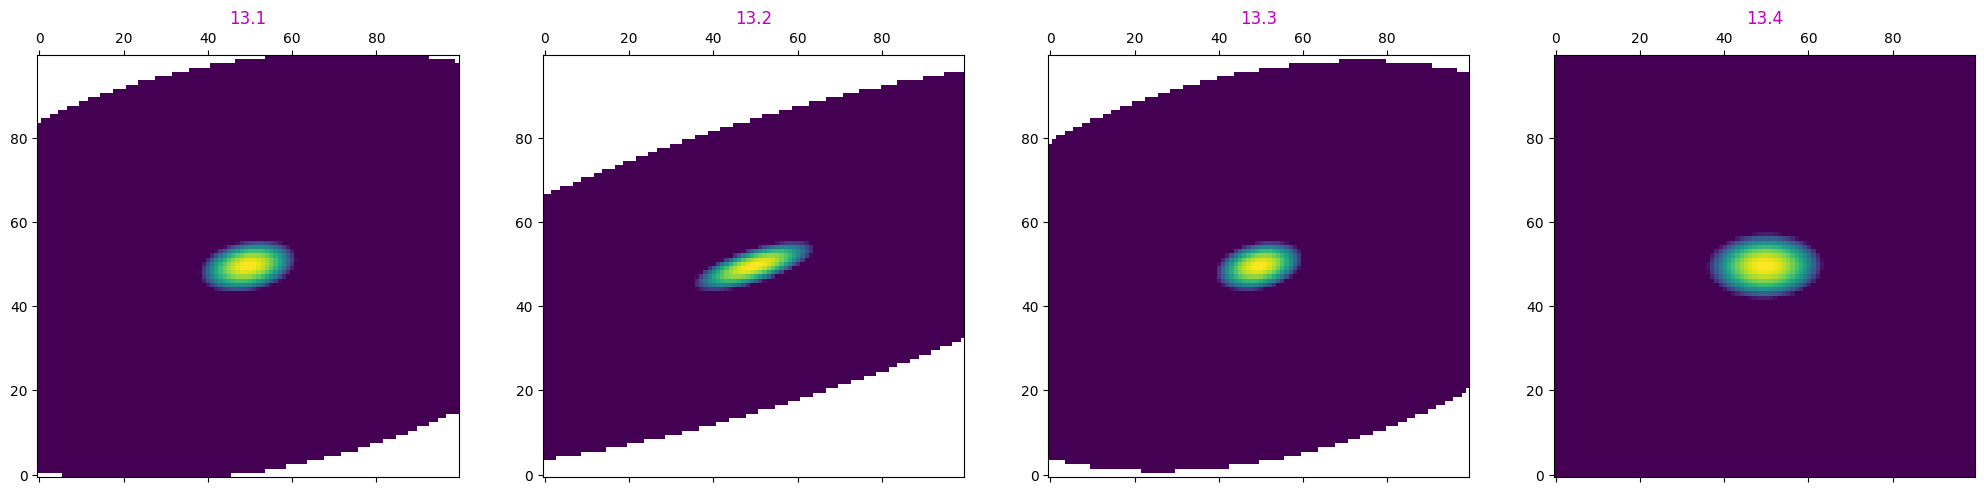

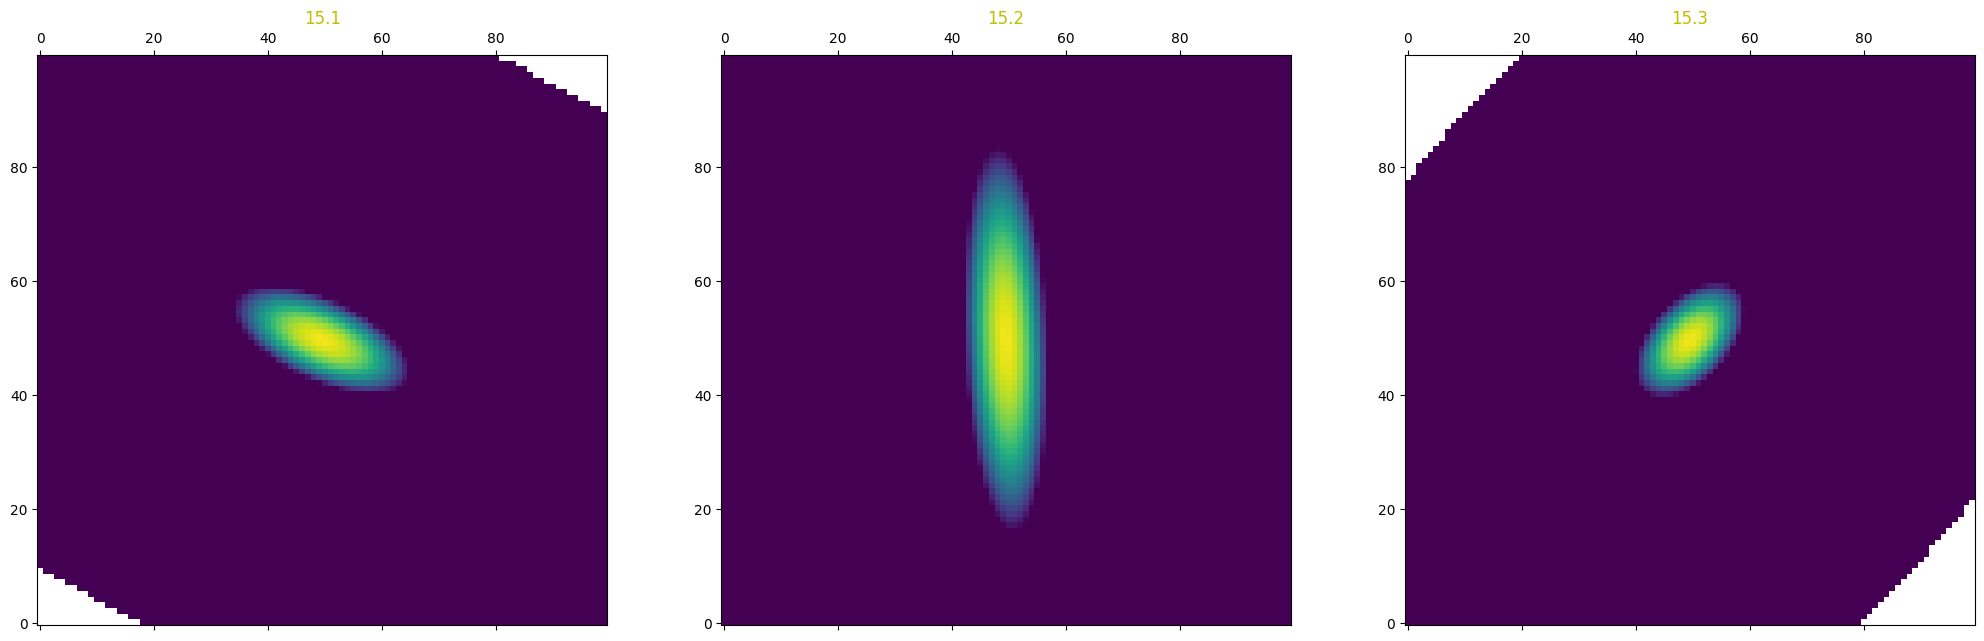

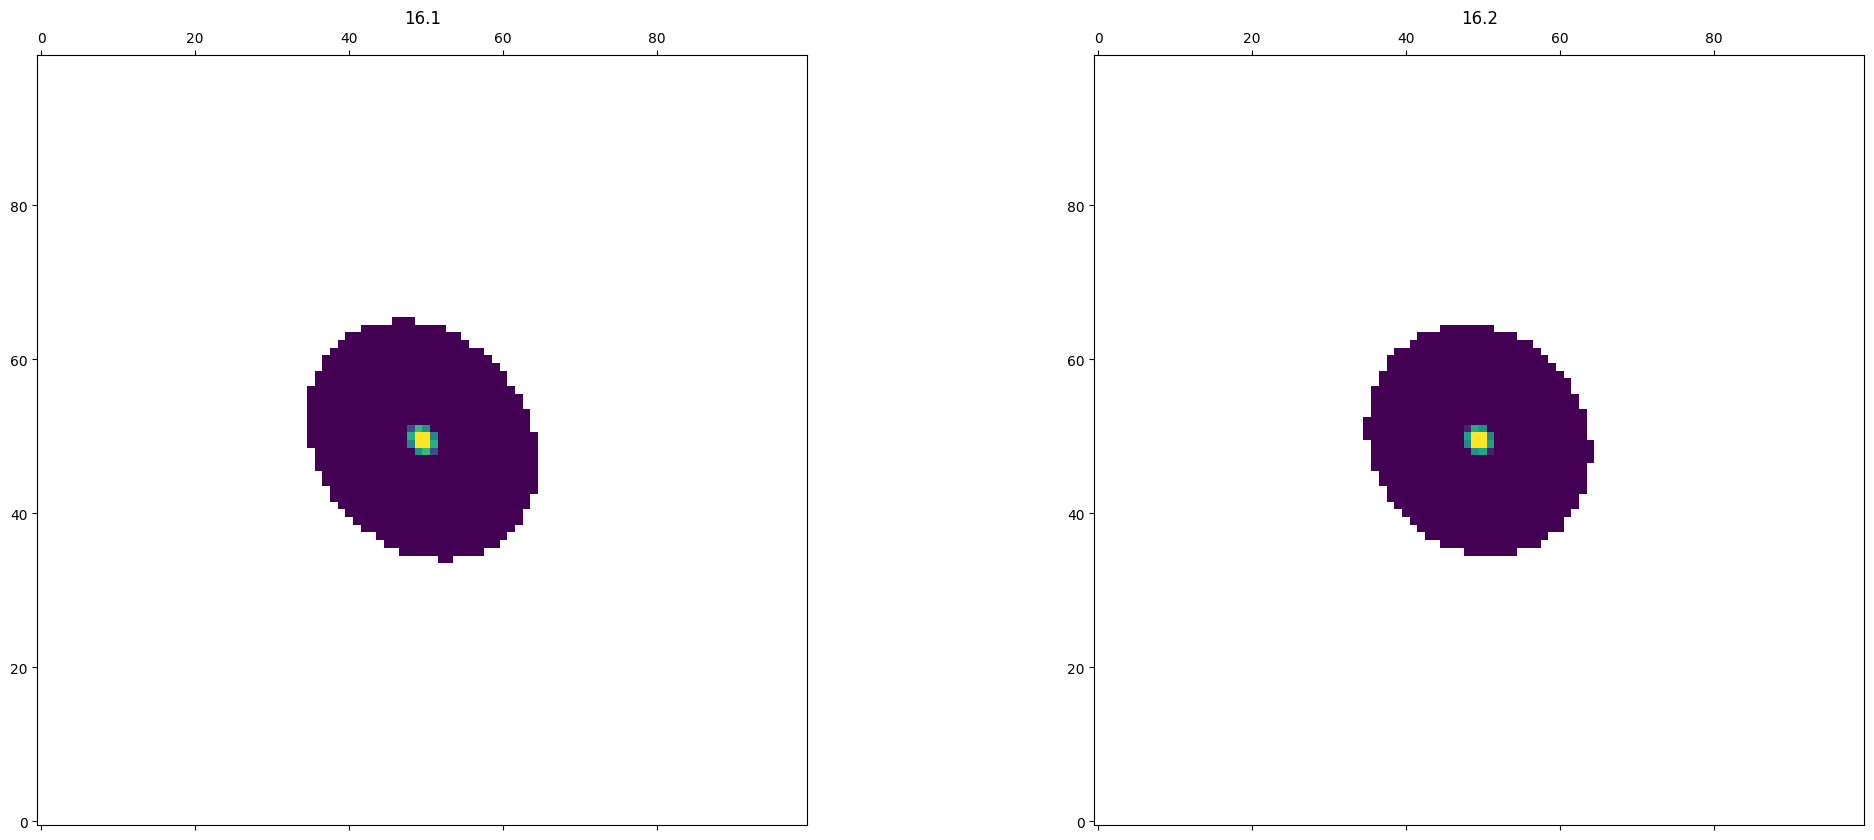

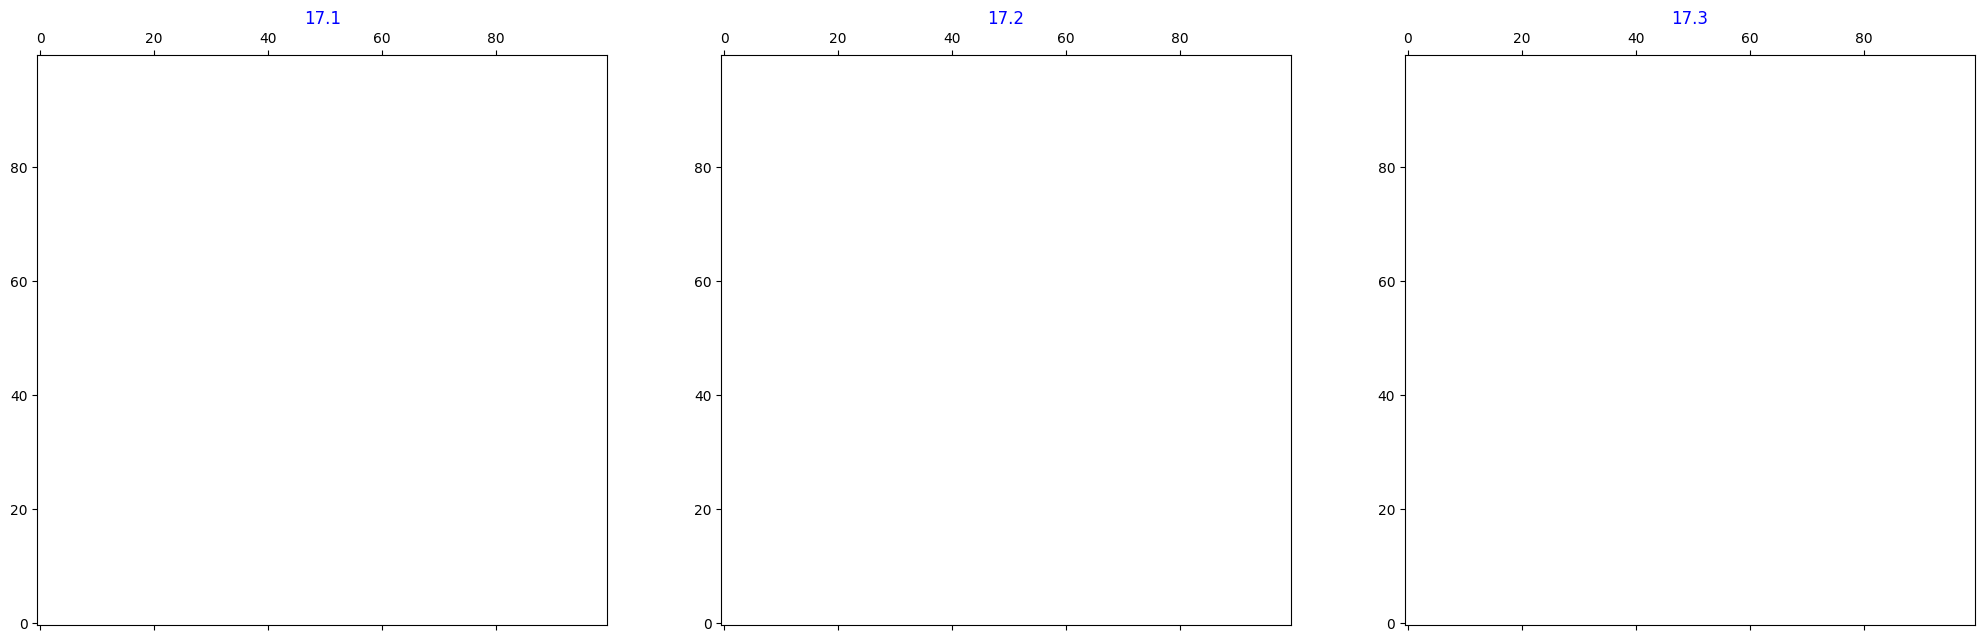

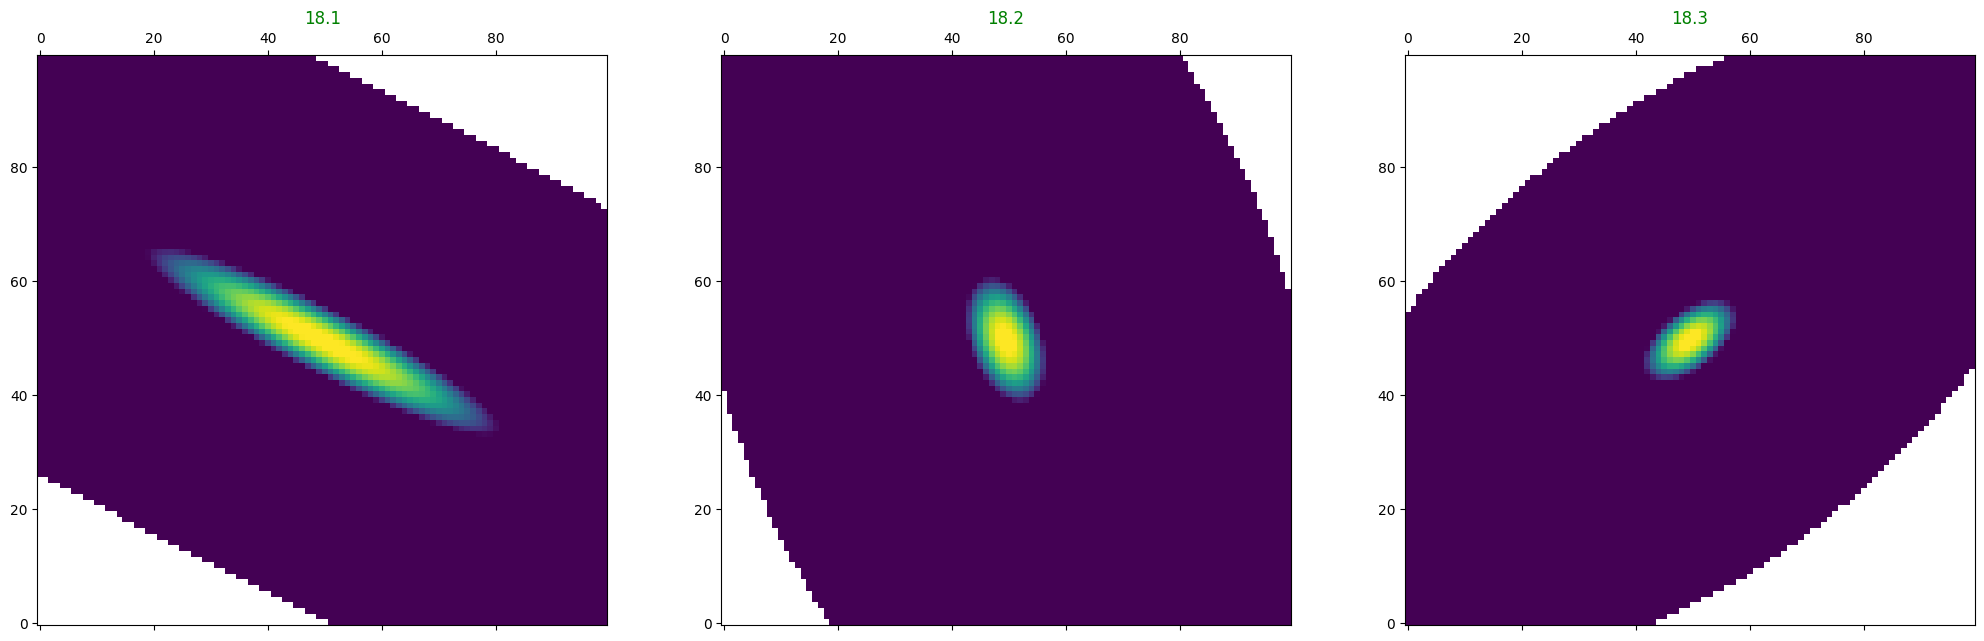

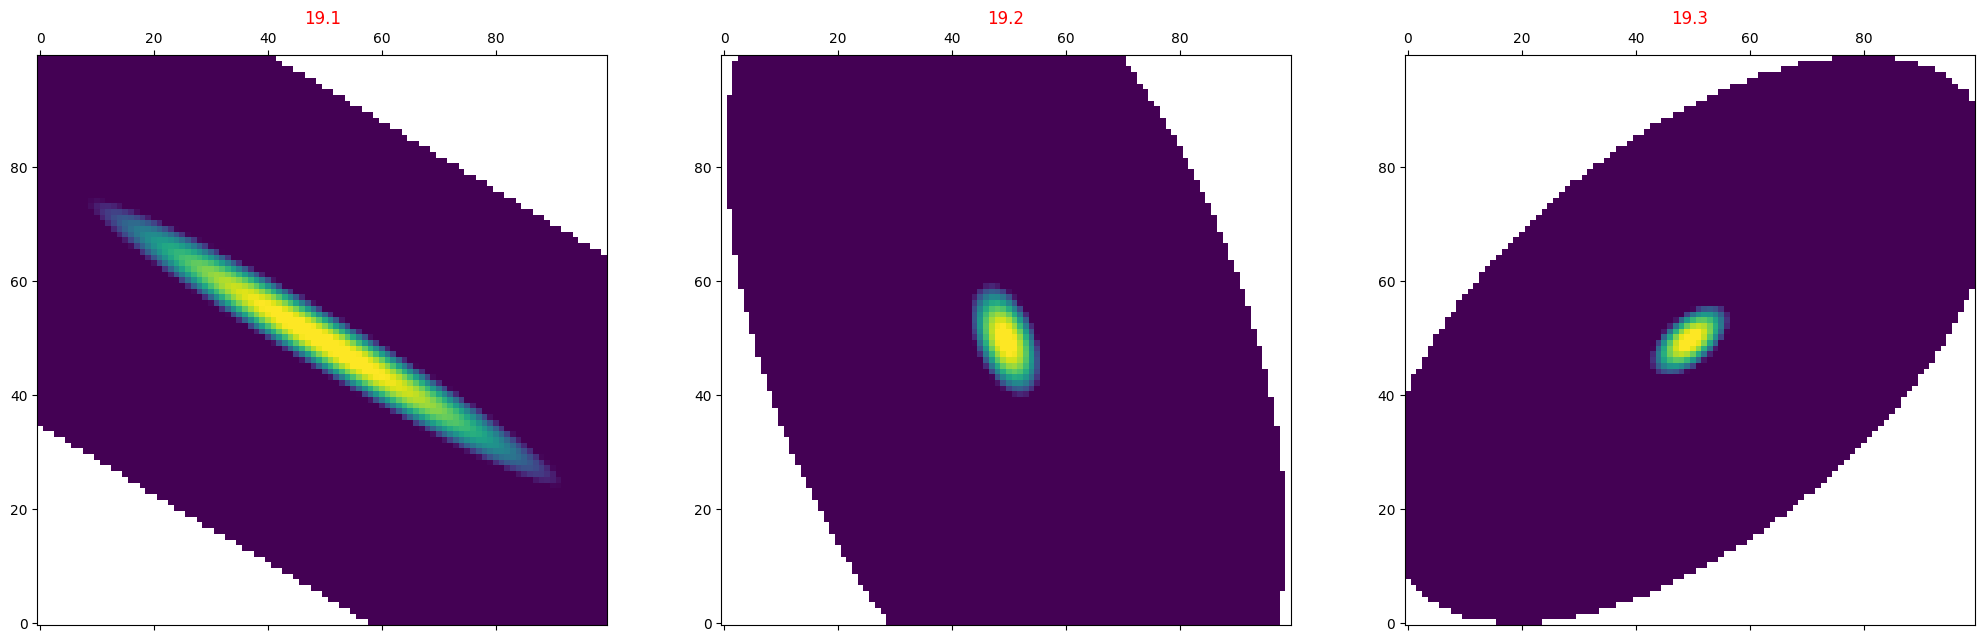

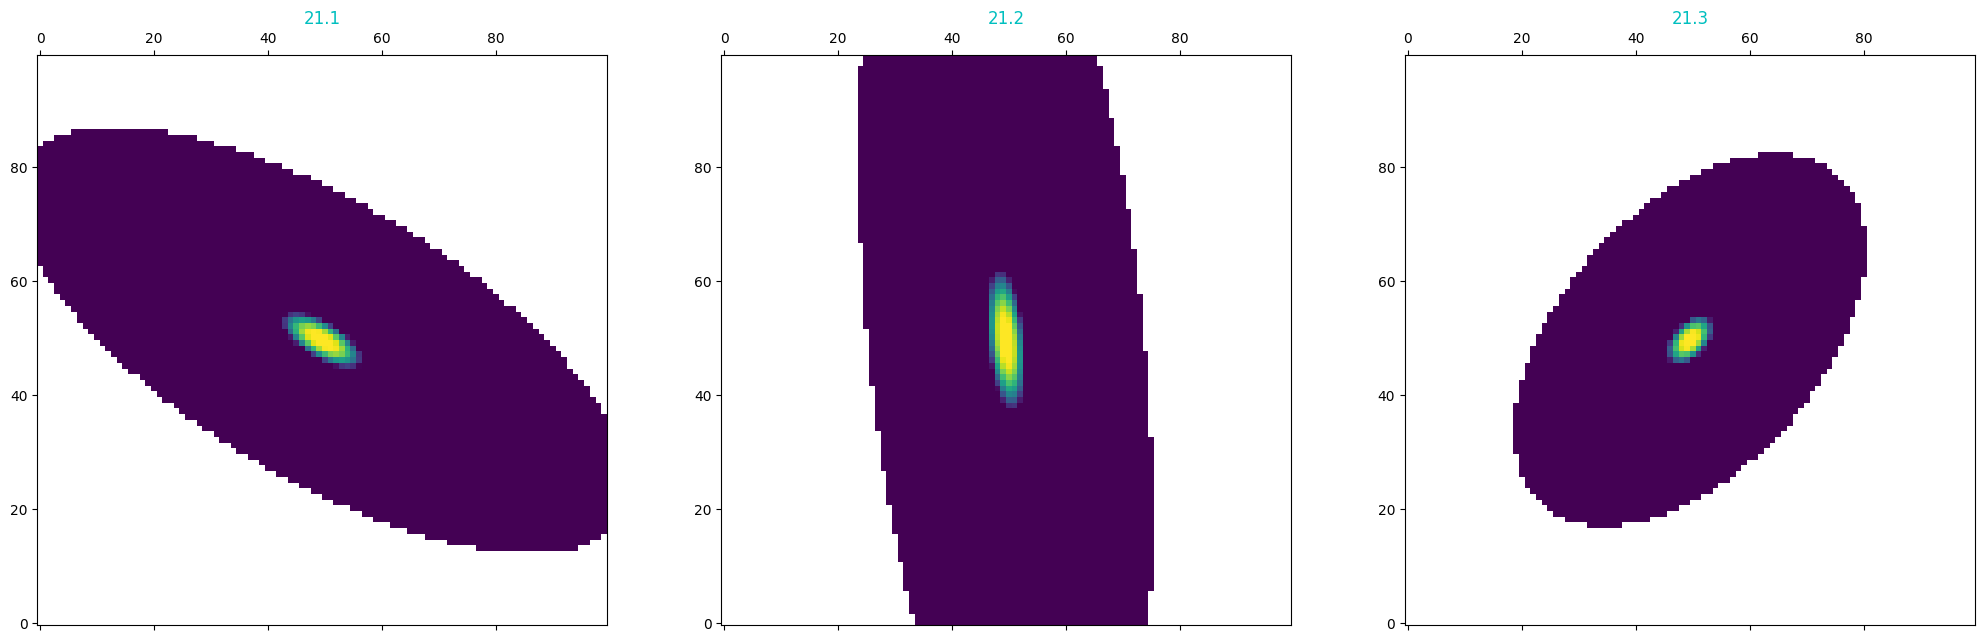

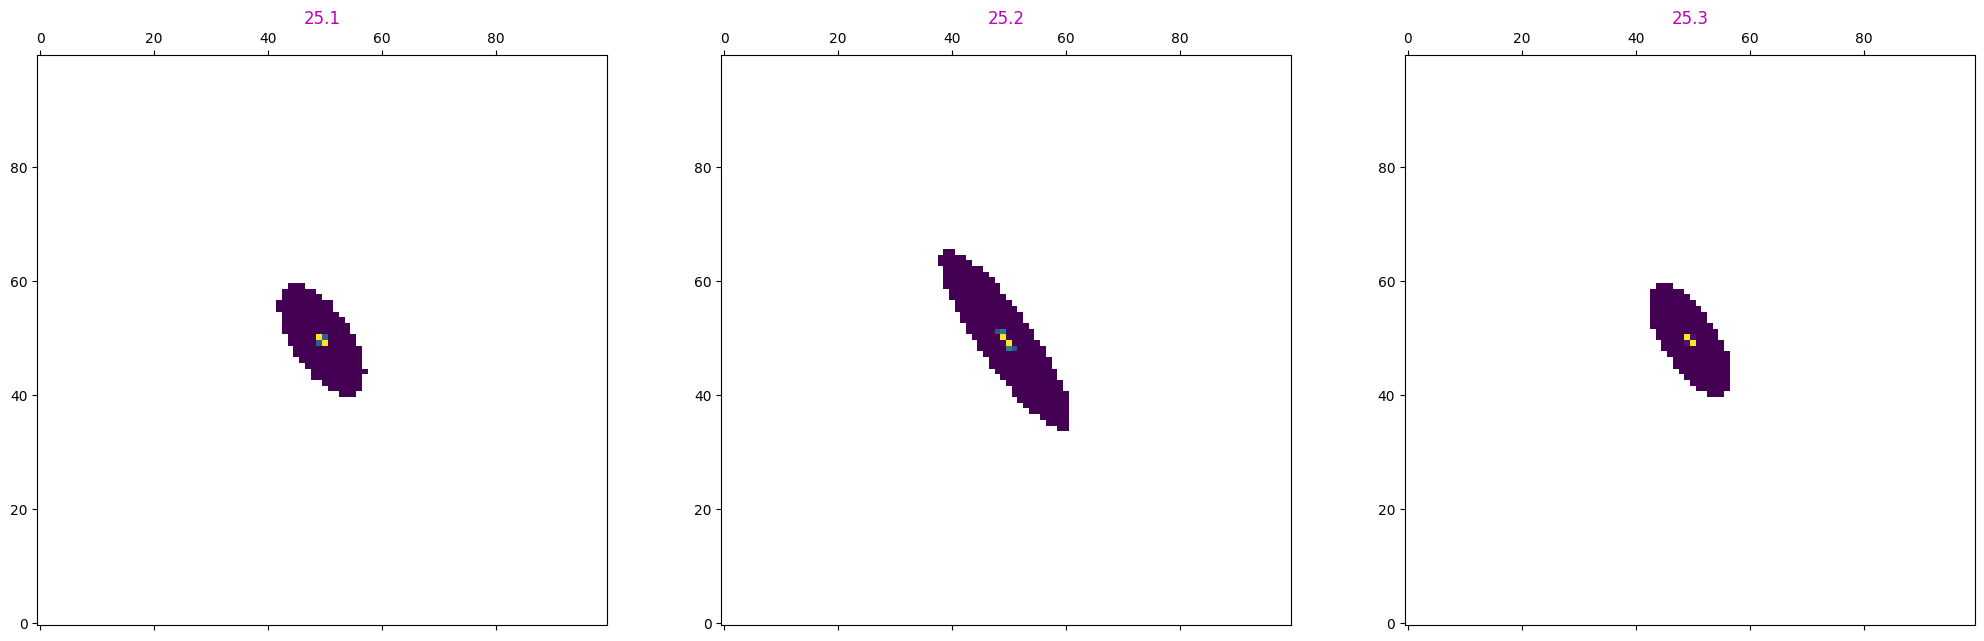

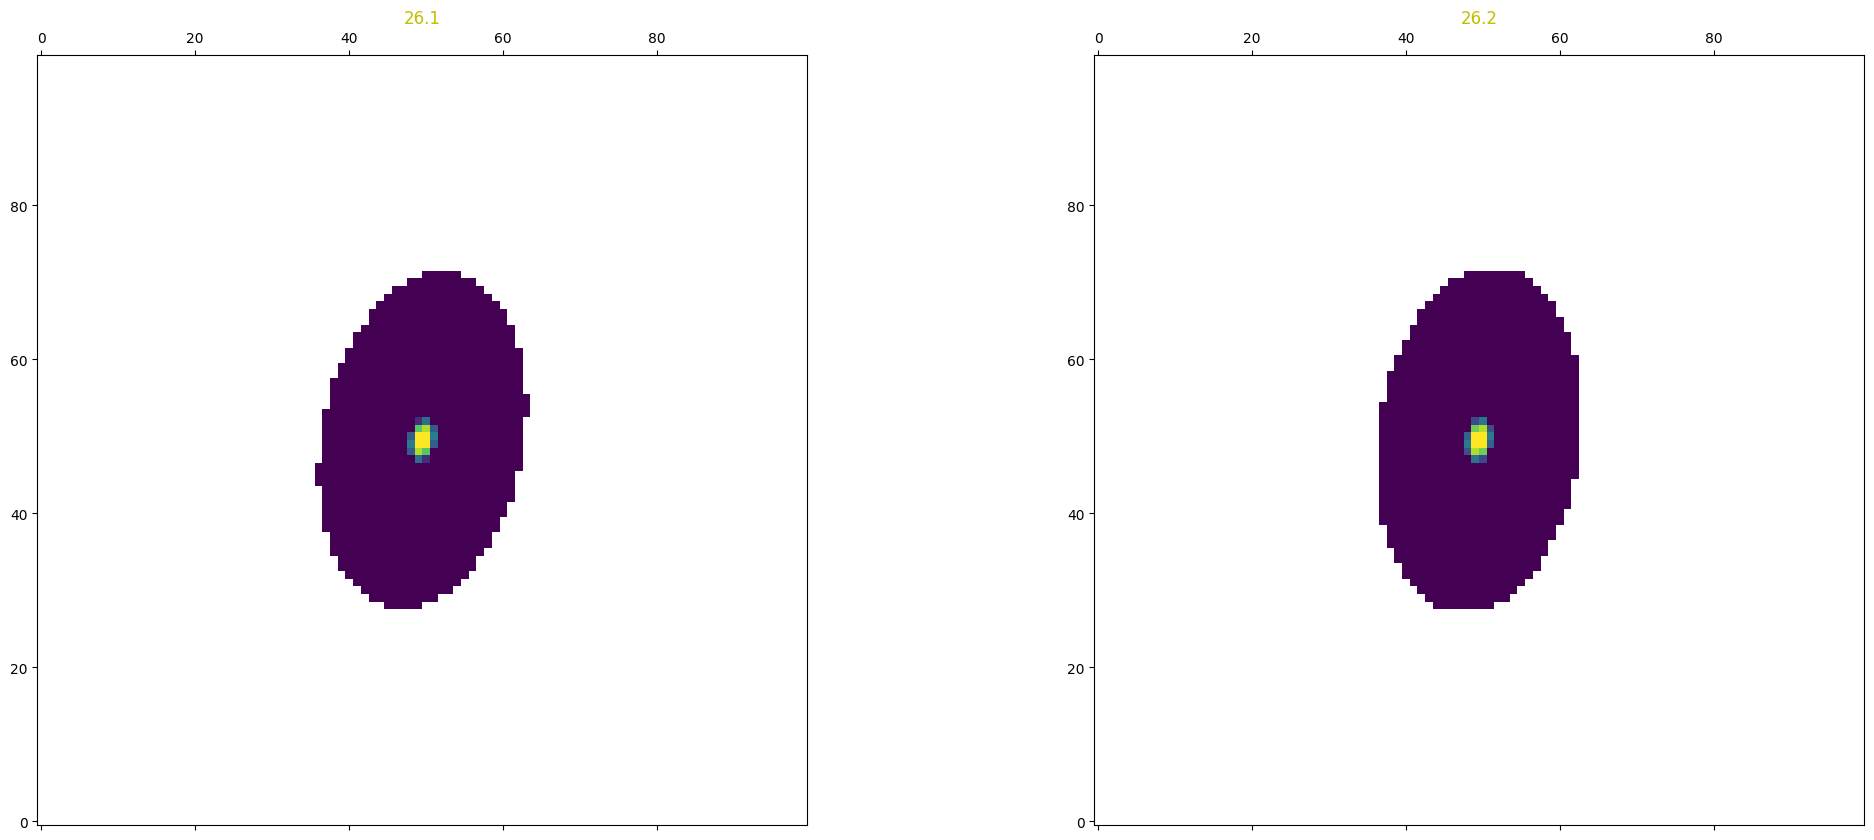

In [14]:
# here we plot the finite sources as seen at the different image positions
label_lists = []
for i in range(num_sources_data):
    label_list_temp = [None] * len(grouped_x_imgs[i])
    label_lists.append(label_list_temp)

if (Name_list is not None) & (num_Names == 1):
    for i in range(num_sources_data):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
        x_img_indexed = grouped_x_imgs[i]
        y_img_indexed = grouped_y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(grouped_x_imgs[i])):
            label_lists[i][j] = grouped_ids[i][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[k]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_lists[i][k], color=color_list[i])
        plt.show()
elif (Name_list is not None) & (num_Names > 1):
    for i in range(num_sources_data):
        lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
        x_img_indexed = grouped_x_imgs[i]
        y_img_indexed = grouped_y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        for j in range(len(grouped_x_imgs[i])):
            label_lists[i][j] = grouped_ids[i][j]
        for k in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[k], y_pos=y_img_indexed[k], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[i], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[k]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_lists[i][k], color=color_list[i])
        plt.show()
else:
    for i in range(num_sources_data):
        x_img_indexed = grouped_x_imgs[i]
        y_img_indexed = grouped_y_imgs[i]
        f, axes = plt.subplots(1, len(x_img_indexed), figsize=(5*5, 5*len(x_img_indexed)), sharex=False, sharey=False)
        label_list = [f"{i+1}A", f"{i+1}B", f"{i+1}C", f"{i+1}D", f"{i+1}E", f"{i+1}F", f"{i+1}G", f"{i+1}H", f"{i+1}I", f"{i+1}J", f"{i+1}K"]
        for j in range(len(x_img_indexed)):
            lensModelExtensions._lensModel.change_source_redshift(z_source=z_sources_new[i])
            image = lensModelExtensions.zoom_source(x_pos=x_img_indexed[i], y_pos=y_img_indexed[i], kwargs_lens=kwargs_lens, 
                                                            source_sigma=source_sizes_arcsec[j], window_size=window_size,
                                                            grid_number=grid_number)
            ax = axes[i]
            ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
            ax.set_title(label_list[i], color=color_list[i])
        plt.show()

## Set up data for modeling
Now that we have read in all our data and completed the necessary calculations, we can explicitly set up the data in the way we want to use for modeling.
This includes set up of the uncertainty for each value, including flux ratios, time delays, and image positions.

In this section, we explicitly set up the data products that we want to use for the modeling. You can replace this box with the values for the lens you want to model.

In [15]:
## Here we calculate the flux ratio between the different images from the same source. We then also add a sigma to the values to account for error

flux_ratios_list = []
flux_ratio_errors_list = []
flux_ratios_measured_list = []

for i in range(num_sources_data):
    image_amps = np.abs(mag_infs[i])
    flux_ratios = image_amps[1:]/image_amps[0]
    flux_ratio_errors = 0.02*np.ones(len(flux_ratios))
    flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
    if measurement_realization:
        flux_ratios_measured = flux_ratios + np.random.normal(0, flux_ratio_errors)
    else:
        flux_ratios_measured = flux_ratios
    flux_ratios_list.append(flux_ratios)
    flux_ratio_errors_list.append(flux_ratio_errors)
    flux_ratios_measured_list.append(flux_ratios_measured)
print('flux_ratios_list: %s' %(flux_ratios_list))

# image positions in relative RA (arc seconds)
astrometry_sigma = 0.005  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision for all images in RA/DEC directions)

## Here we loop to calculate the time delays
d_dts = []
d_dt_sigmas = []
d_dt_measured_list = []
ximg_measured_list = []
yimg_measured_list = []

for i in range(num_sources_data):
    d_dt = t_days[i][1:] - t_days[i][0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
    d_dt_sigma = 0.5 * np.ones(len(d_dt))
    d_dts.append(d_dt)
    d_dt_sigmas.append(d_dt_sigma)
    
    if measurement_realization:
        d_dt_measured = d_dt + np.random.normal(0, d_dt_sigma)
        ximg_measured = grouped_x_imgs[i] + np.random.normal(0, astrometry_sigma, len(grouped_x_imgs[i]))
        yimg_measured = grouped_y_imgs[i] + np.random.normal(0, astrometry_sigma, len(grouped_y_imgs[i]))
    else:
        d_dt_measured = d_dt
        ximg_measured = grouped_x_imgs[i]
        yimg_measured = grouped_y_imgs[i]

    d_dt_measured_list.append(d_dt_measured)
    ximg_measured_list.append(ximg_measured)
    yimg_measured_list.append(yimg_measured)

# here we create a keyword list with all the data elements. If you only have partial information about your lens, only provide the quantities you have.
# kwargs_time_delays_list = []
# kwargs_time_delay_uncertainties_list = []
# kwargs_flux_ratios_list = []
# kwargs_flux_ratio_errors_list = []
kwargs_ra_image_list = []
kwargs_dec_image_list = []


for i in range(num_sources_data):
    # kwargs_time_delays_list.append(d_dt_measured_list[i])
    # kwargs_time_delay_uncertainties_list.append(d_dt_sigmas[i])
    # kwargs_flux_ratios_list.append(flux_ratios_measured_list[i])
    # kwargs_flux_ratio_errors_list.append(flux_ratio_errors_list[i])
    kwargs_ra_image_list.append(ximg_measured_list[i])
    kwargs_dec_image_list.append(yimg_measured_list[i])

kwargs_data_joint = {'ra_image_list': kwargs_ra_image_list, 'dec_image_list': kwargs_dec_image_list}
    #                  'time_delays_measured': kwargs_time_delays_list,
    #                  'time_delays_uncertainties': kwargs_time_delay_uncertainties_list,
    #                  'flux_ratios': kwargs_flux_ratios_list, 
    #                  'flux_ratio_errors': kwargs_flux_ratio_errors_list,
    # don't add this:  'point_source_redshift_list': z_sources_new}

# print("time delay measured", kwargs_data_joint["time_delays_measured"])
# print('ra kwargs: %s \ndec kwargs: %s' %(kwargs_ra_image_list, kwargs_dec_image_list))

flux_ratios_list: [array([2.48143117, 6.96033332]), array([7.5821401 , 6.05038333]), array([1.08781962, 1.64915666, 1.9357879 ]), array([1.40553419, 1.72949596]), array([0.08508568, 0.05400981]), array([1.72691319, 0.79889613]), array([1.10154266, 1.00032676]), array([1.27134665]), array([1.32483809]), array([0.20272076, 0.19210771]), array([1.20630712]), array([1.88949098, 0.68965758]), array([0.8889793 , 0.85663596, 1.52030375]), array([2.07127584, 0.69912625]), array([0.94631609]), array([2.80480536, 0.25544793]), array([0.37504151, 0.24992134]), array([0.23765046, 0.1542041 ]), array([1.55948269, 0.59984678]), array([1.52860002, 0.91235299]), array([1.02694846])]


## Model settings
Here we set up the modeling. For each lens mass and the dark matter halo, a new instance of the initial guess of the parameters, uncertainties and lower and upper bounds must be included, each added to the appropriate kwargs dictionary. These values should match what is used in the lensing profiles that were chosen.
In this example, we use the same lens model as we chose earlier to generate the plots, etc. In the pure modeling notebook, as we choose the same lens model for both, we might expect a perfect fit. However, with real data, this is less likely.

This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for more details.

In [16]:
# ==================
# lens model choices
# ==================
# this is where things need to be updated to make it fit the new cluster model! Need essentialy a loop to get through each cluster member and then add each one to the kwargs list.
# could also add things that are known very well to the fixed_lens.append({}) list, ie. this could be not empty!

# here we would pick the one we think would fit the image best? Is there some way to know which model we expect to fit best before we run the code?


### for Setting the galaxy lens parameters
# combine the append of all these at the same time as the lens_model_list

##### # fix the relative scaling of one deflector and another
# define the scaling ratio with the luminosity with E_radius, fix that, scale up or down all the E_radius simultaneously
    # might be a notebook for this, otherwise, see sampling --> special_param.py
    # mass_scaling (bool) and num_scaling_factor (int) parameters
    # scale factor in
    # should fix theta_E if varying this

## settings for kwargs_constraints (Param() class)
# mass_scaling = True  # if True, samples scaling parameters
# num_scale_factor = 1  # number of scaling parameters being sampled

mass_scaling_list = []  # False or integer for each mass model, integer, model theta_E gets multiplied with the saling parameter[integer - 1]
for i in range(len(gal_data_arcsec)):
    mass_scaling_list.append(1)
mass_scaling_list.append(False)


## we have previously defined our lens_model_list as we needed it for calculations/plotting above. If not defined above, uncomment it below.
# lens_model_list = []
# for i in range(len(gal_data_arcsec)):
#     lens_model_list.append('PJAFFE_ELLIPSE_POTENTIAL')
# lens_model_list.append('NFW_ELLIPSE_CSE')

## fixed_lens values here
fixed_lens = []
for i in range(len(gal_data_arcsec)):
    fixed_lens.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})
fixed_lens.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})

kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# SPEMD parameters
# for i in range(len(lens_model_list)):
#     fixed_lens.append({})

# append once for each of the cluster members, then once for the dark matter halo
for i in range(len(gal_data_arcsec)):
    # initial parameter guess
    kwargs_lens_init.append({'sigma0': dPIED_sigma_0s[i], "e1": e1s[i], "e2": e2s[i], 'Ra': float(gal_data_arcsec['a'].iloc[i]), 'Rs': Rt_star_kpc, 'center_x': float(gal_data_arcsec['RA'].iloc[i]), "center_y": float(gal_data_arcsec['DEC'].iloc[i])})    # (kwargs_lens[i])     # {"theta_E": 0.2, "e1": e1s[i], "e2": e2s[i], "center_x": gal_data_arcsec['RA'].iloc[i], "center_y": gal_data_arcsec['DEC'].iloc[i]})
    # initial particle cloud
    kwargs_lens_sigma.append({'sigma0': 0.01, 'e1': 0.01, 'e2': 0.01, 'Ra': 1.0, 'Rs': 17, 'center_x': 0.1, 'center_y': 0.1})
    # hard lower bound limit of parameters
    kwargs_lower_lens.append({'sigma0': 0, 'e1': -0.5, 'e2': -0.5, 'Ra': 0, 'Rs': 0, 'center_x': -100, 'center_y': -100})
    # hard upper bound limit of parameters
    kwargs_upper_lens.append({'sigma0': 10, 'e1': 0.5, 'e2': 0.5, 'Ra': 100, 'Rs': 100, 'center_x': 100, 'center_y': 100})

# same kwargs but for the nfw dark matter halo
kwargs_lens_init.append({"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})   # (kwargs_lens[-1])        # {"Rs": nfw_Rs, "alpha_Rs": nfw_alpha_Rs, "e1": nfw_e1, "e2": nfw_e2, "center_x": float(input_data_frame['Value'].iloc[62][0]), "center_y": float(input_data_frame['Value'].iloc[63][0])})
kwargs_lens_sigma.append({"Rs": 0.1, "alpha_Rs": 0.1, "e1": 0.01, "e2": 0.01, "center_x": 0.1 , "center_y": 0.01})
kwargs_lower_lens.append({"Rs": 0, "alpha_Rs": 0, "e1": -0.5, "e2": -0.5, "center_x": -100, "center_y": -100})
kwargs_upper_lens.append({"Rs": 100, "alpha_Rs": 10, "e1": 0.5, "e2": 0.5, "center_x": 100, "center_y": 100})

# SHEAR parameters
# we keep the center of shear definition fixed at (0,0). Want to make sure that things aren't moving, they're just being sheared?
# for i in range(len(lens_model_list)):
    # fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    # kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
    # kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    # kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
    # kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

# combine all parameter options for lenstronomy
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
print('kwargs_lens_init len: %s, data: %s' %(len(kwargs_lens_init), kwargs_lens_init))
print('fixed_lens len: %s, data: %s' %(len(fixed_lens), fixed_lens))
print('kwargs_lens_sigma_list len: %s, data: %s' %(len(kwargs_lens_sigma), kwargs_lens_sigma))
print('kwargs_lower_lens_list len: %s, data: %s' %(len(kwargs_lower_lens), kwargs_lower_lens))
print('kwargs_upper_lens_list len: %s, data: %s' %(len(kwargs_upper_lens), kwargs_upper_lens))

kwargs_lens_init len: 149, data: [{'sigma0': 0.5314788707712829, 'e1': -0.04904835144227604, 'e2': -0.22685761014482453, 'Ra': 0.6012, 'Rs': 20, 'center_x': -11.28084356039193, 'center_y': 87.10452000002533}, {'sigma0': 1.0141147947097064, 'e1': 0.0004096789801026205, 'e2': -0.002646365214279174, 'Ra': 0.2628, 'Rs': 20, 'center_x': 44.81321822663787, 'center_y': 25.266959999981964}, {'sigma0': 0.8716833245517415, 'e1': 0.013853329148482103, 'e2': -0.055562668414728456, 'Ra': 0.29, 'Rs': 20, 'center_x': -44.524691857738794, 'center_y': -73.59227999999689}, {'sigma0': 0.8798550360951061, 'e1': -0.021693684005130647, 'e2': -0.03526258007598605, 'Ra': 0.255, 'Rs': 20, 'center_x': -0.041686226860088195, 'center_y': 0.04931999998802894}, {'sigma0': 0.8405478632314907, 'e1': -0.04280093462643234, 'e2': -0.0008965517729663222, 'Ra': 0.265, 'Rs': 20, 'center_x': 34.281678039568405, 'center_y': 22.06692000000885}, {'sigma0': 0.8600737221436404, 'e1': 0.012975965144632111, 'e2': -0.00561520153853

Now we do the same for the image parameters, including an initial guess, uncertainty, and upper and lower limits for each instance. This is also where we can choose to include 'special' parameters, such as astrometric perturbations, time delay distances, or quasar soruce information if relevant.
We can choose here to fix the x and y position parameters if desired, removing one degree of freedom from our model.

In [17]:
# =========================
# image position parameters
# =========================

# we chose to model the image positions in the lensed plane (we know where they appear) and fix the image position coordinates
point_source_list = []
fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []

for i in range(num_sources_data):
    point_source_list.append('LENSED_POSITION')
    fixed_ps.append({'ra_image': ximg_measured_list[i], 'dec_image': yimg_measured_list[i]})  # we fix the image position coordinates
    kwargs_ps_init.append({'ra_image': ximg_measured_list[i], 'dec_image': yimg_measured_list[i]})
    kwargs_ps_sigma.append({'ra_image': 0.01 * np.ones(len(grouped_x_imgs[i])), 'dec_image': 0.01 * np.ones(len(grouped_y_imgs[i]))})
    kwargs_lower_ps.append({'ra_image': -10 * np.ones(len(grouped_x_imgs[i])), 'dec_image': -10 * np.ones(len(grouped_y_imgs[i]))})
    kwargs_upper_ps.append({'ra_image': 10* np.ones(len(grouped_x_imgs[i])), 'dec_image': 10 * np.ones(len(grouped_y_imgs[i]))})

# combine all parameter options for lenstronomy
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

# =========================
# astrometric perturbations
# =========================
# astrometric perturbations are modeled in lenstronomy with 'delta_x_image' and 'delta_y_image'.
# These perturbations place the 'actual' point source at the difference to 'ra_image'.
# we let some freedom in how well the actual image positions are matching those given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)

#kwargs_special_init['delta_x_image'], kwargs_special_init['delta_y_image'] = np.zeros_like(ximg), np.zeros_like(yimg)
#kwargs_special_sigma['delta_x_image'], kwargs_special_sigma['delta_y_image'] = np.ones_like(ximg) * astrometry_sigma, np.ones_like(yimg) * astrometry_sigma
#kwargs_lower_special['delta_x_image'], kwargs_lower_special['delta_y_image'] = np.ones_like(ximg) * (-1), np.ones_like(yimg) * (-1)
#kwargs_upper_special['delta_x_image'], kwargs_upper_special['delta_y_image'] = np.ones_like(ximg) * (1), np.ones_like(yimg) * (1)

# ==================
# quasar source size
# ==================
# # If you want to keep the source size fixed during the fitting, don't comment the line below (or comment the line to let it vary).
# fixed_special['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_init['source_size'] = [source_size_arcsec, source_size_arcsec2]
# kwargs_special_sigma['source_size'] = [source_size_arcsec, source_size_arcsec2]
# or:
# kwargs_special_init['source_size'] = source_sizes_arcsec[0]
# kwargs_special_sigma['source_size'] = source_sizes_arcsec[0]
# fixed_special['source_size'] = source_sizes_arcsec[0]

# kwargs_lower_special['source_size'] = 0.0001
# kwargs_upper_special['source_size'] = 1


# ===================
# Time-delay distance
# ===================
# with time-delay information, we can measure the time-delay distance (units physical Mpc)

# if you want to fix the cosmology and instead use the time-delay information to constrain the lens model, out-comment the line below
    # essentially, choose either the first line of the above block of code, or the first line of the below block of code
#fixed_special['D_dt'] = lensCosmo.D_dt
# kwargs_special_init['D_dt'] = lensCosmo.ddt
# kwargs_special_sigma['D_dt'] = 2000
# kwargs_lower_special['D_dt'] = 0
# kwargs_upper_special['D_dt'] = 10000

# mass scaling parameter configuraiton
kwargs_special_init['scale_factor'] = [1]       #### Does this get replaced with the mass scaling relationships from the calculations above?
kwargs_special_sigma['scale_factor'] = [0.2]
kwargs_lower_special['scale_factor'] = [0]
kwargs_upper_special['scale_factor'] = [10]

special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]
print("special_params:", special_params)

# combined parameter settings
kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'special': special_params}

# our model choices
kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list,
                'point_source_redshift_list': z_sources_new,           # add this for changing redshifts of sources!
                'z_source_convention': z_source_convention,
                'z_lens': z_lens,
                'cosmo': cosmo}

print("point_source_list:", point_source_list)
print("fixed_lens:", fixed_lens)
print("fixed_ps:", fixed_ps)
print("fixed_special:", fixed_special)
print("kwargs_special_init:", kwargs_special_init)

special_params: [{'scale_factor': [1]}, {'scale_factor': [0.2]}, {}, {'scale_factor': [0]}, {'scale_factor': [10]}]
point_source_list: ['LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION', 'LENSED_POSITION']
fixed_lens: [{'sigma0': 0.5314788707712829, 'e1': -0.04904835144227604, 'e2': -0.22685761014482453, 'Ra': 0.6012, 'Rs': 20, 'center_x': -11.28084356039193, 'center_y': 87.10452000002533}, {'sigma0': 1.0141147947097064, 'e1': 0.0004096789801026205, 'e2': -0.002646365214279174, 'Ra': 0.2628, 'Rs': 20, 'center_x': 44.81321822663787, 'center_y': 25.266959999981964}, {'sigma0': 0.8716833245517415, 'e1': 0.013853329148482103, 'e2': -0.055562668414728456, 'Ra': 0.29, 

## setup options for likelihood and parameter sampling
In $\texttt{lenstronomy}$ the likelihood settings (which likelihood gets evaluated) and the parameter sampling options (which parameters get sampled) are separated. It is upon the user to decide the appropriate parameters to be sampled for the given choice of likelihood and information.

In [18]:
# so I'd have to turn these on or off depending on what model/information I have
time_delay_likelihood = False     # bool, set this True or False depending on whether time-delay information is available and you want to make use of its information content.
flux_ratio_likelihood = False     # bool, modeling the flux ratios of the images
image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

kwargs_flux_compute = {'source_type': 'INF',        # you can either chose 'INF' which is a infinetesimal source size, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size,  # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number}  # number of grid points (per axis) to compute the extended source surface brightness within the window_size around the image position

kwargs_constraints = {'num_point_source_list': num_images_list,
                        # 'Ddt_sampling': time_delay_likelihood,
                      'mass_scaling_list': mass_scaling_list
                      } # sampling of the time-delay distance

# ATTENTION: make sure that the numerical options are chosen to provide accurate computations for the finite source magnifications!
if kwargs_flux_compute['source_type'] in ['GAUSSIAN', 'TORUS'] and flux_ratio_likelihood is True:
    kwargs_constraints['source_size'] = True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS')

# we can define un-correlated Gaussian priors on specific parameters explicitly
# e.g. power-law mass slope of the main deflector
# prior_lens = [[0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01]] # [[0, 'gamma', 2, 0.1],[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
# prior_lens_light = []
# prior_special = []
    
kwargs_likelihood = {'image_position_uncertainty': astrometry_sigma,  # astrometric uncertainty of image positions
                     'image_position_likelihood': True,               # evaluate point source likelihood given the measured image positions
                     'time_delay_likelihood': False,                  # evaluating the time-delay likelihood
                     'flux_ratio_likelihood': False,                  # enables the flux ratio likelihood 
                     'kwargs_flux_compute': kwargs_flux_compute,      # source_type='INF' will lead to point source
                    # 'prior_lens': prior_lens,
                    # 'prior_lens_light': prior_lens_light,
                    # 'prior_special': prior_special,
                     'check_bounds': True                            # check parameter bounds and punish them
                    }

## Multiple image position constraints
Matching multiple image position constraints from the same source is a difficult and computationally tedious task. Here we discuss a few different approaches, their pros and cons and how they are implemented in lenstronomy.

1. Sampling the source position and solving the lens equation: The conceptually most straight forward approach is to sample the source position and the lens model and then compute the image positions by solving the lens equation. Apart from having the model priors well under control, this method comes with some draw-backs: (1) Solving the lens equation is computationally expensive. (2) small changes in the source position lead to significant changes in the predicted image positions in highly magnified regions and the sampling becomes inefficient. (3) the number of images appearing is not preserved and different predicted positions can not unambiguosly be matched to data points.
Lenstronomy can deal with the sampling of the source position but the image positions can not be dealt with in catalogue form but only in terms of a simulated image. This method is not recommended.

2. Sampling the image position and ray-tracing to the source position: Computationally much easier and with parameters reflecting the data much closer is chosing the image position as the sampling parameters and ray-trace back to the source plane to compute the source position. The problem: In general, the different images do not match precisely back to the same source position and the lens equation can be severely invalidated. Satisfying the lens equation is key in accurately predicting the relative time delays. Errors introduced when not matching the lens equation are discussed e.g. in Birrer & Treu 2019.
The work-around in lenstronomy: You can introduce a punishing term in the likelihood to downweight proposed models that do not meet a certain requirement in how accurately the lens equation is satisfied. In the limit of having infinite requirements on the lens equation, sampling becomes untractable. Even when the desire is having very high accuracy, sampling will lead to a non-linear degeneracy as effectively the number of sampled parameters (2x number of image positions - 2 source positions) is under-constrained. The numerical precision has to be carefully chosen to gage accuracy vs. sampling efficiency. Also: the numerical precision imposed is effectively a prior in the sampling! The numerical precision must be chosen magnification-independent to not propagate to a prior in e.g. the power-law slope inference. Lenstronomy deals with it by imposing the required source position accuracy as magnified in the image plane to avoid biases.

3. Non-linear solving of lens model parameters to satisfy the lens equation: A way to circumvene the issue of the under-constraint sampling in (2) still taking the benefit of not solving the lens equation is to constrain part of the lens model through applying a non-linear solver on the ray-tracing to match the source position. This is faster than solving the lens equation and provides an efficient sampling as the parameters are the image positions. A possible draw-back is the behaviour of the solver and the prior on these constraint model parameters are not well phrased. The advantage is that all proposed models are a solution to the lens equation to high numerical precision.

4. Fixing image position and translating astrometric uncertainties to the source plane: This is a fast and efficient method to allow for constraints on lens model parameters from multiply observed images. However the lens models that are being sampled do not satisfy the lens equation. When computing the time delays, the image positions have to be computed for the proposed lens model by solving the lens equation and at these positions the Fermat potential/time delay needs to be evaluated.

In [19]:
# setting the non-linear solver accoring to option (3)
kwargs_constraints['solver_type'] = 'NONE'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled

# checking for matched source position in ray-tracing the image position back to the source plane.
# This flag should be set =True when dealing with option (2) and (3)
# kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and discard non-solutions # removed by simon in a recent PR
kwargs_likelihood['source_position_tolerance'] = 15  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

# desired precision on r.m.s. scatter in the source plane to achive. 
# This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
# This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failures of the solver.
kwargs_likelihood['source_position_sigma'] = astrometry_sigma

# setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
# Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
# Care has to be taken when requiring time-delay predictions.
kwargs_likelihood['source_position_likelihood'] = True  # evaluates how close the different image positions match the source positons]
kwargs_likelihood['image_position_uncertainty'] = astrometry_sigma  # this option (4) uses the 'image_position_uncertainty' to translate to a source position uncertainty (see also Birrer & Treu 2019)

## log_likelihood test

In [20]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

kwargs_truth = {"kwargs_ps": kwargs_ps_init, "kwargs_lens": kwargs_lens, "kwargs_source": {}, "kwargs_special": kwargs_special_init,
                "kwargs_lens_light": None, "kwargs_tracer_source": None}
log_likelihood = fitting_seq.likelihoodModule.log_likelihood(kwargs_truth, verbose=True)

print(log_likelihood)

Prior likelihood = 0
source position likelihood -74629082.34657492
image position likelihood 0.0
-74629082.34657492


## Distance and Root Mean Square Error calculations of the source positions

In [21]:
func_x_source, func_y_source = fitting_seq.likelihoodModule.PointSource.source_position(kwargs_ps_init, kwargs_lens)

func_diffs_x, func_diffs_y = fitting_seq.likelihoodModule._position_likelihood.source_position_dist(kwargs_ps=kwargs_ps_init, kwargs_lens=kwargs_lens, lens_model=lensModel, z_sources=z_sources_new)
print('Distances (x): %s' %(func_diffs_x))
print('Distances (y): %s' %(func_diffs_y))

func_rmse_x, func_rmse_y = fitting_seq.likelihoodModule._position_likelihood.source_position_rmse(kwargs_ps=kwargs_ps_init, kwargs_lens=kwargs_lens, lens_model=lensModel, z_sources=z_sources_new)
print('RMSE function (x, y): %s, %s' %(func_rmse_x, func_rmse_y))

Distances (x): [array([ 0.24756115,  0.04541801, -0.29297916]), array([ 0.30722478,  0.48353626, -0.79076105]), array([ 0.83641022,  2.46785021, -1.17384017, -2.13042026]), array([ 0.51376516,  1.26996869, -1.78373385]), array([ 0.98914705, -0.32737864, -0.6617684 ]), array([ 0.77206089,  0.93213809, -1.70419898]), array([ 1.27777574,  0.82632641, -2.10410215]), array([-0.7099387,  0.7099387]), array([-0.46047392,  0.46047392]), array([ 1.41867824, -0.61438355, -0.80429469]), array([-0.10710821,  0.10710821]), array([ 2.24244579, -1.4347206 , -0.80772519]), array([ 0.9797453 , -3.04093328, -0.85037101,  2.91155898]), array([ 0.39253715,  0.06013638, -0.45267353]), array([ 0.09512927, -0.09512927]), array([-0.52879589, -1.17373833,  1.70253422]), array([ 1.86416108, -1.45930218, -0.4048589 ]), array([ 1.60766593, -1.31472014, -0.2929458 ]), array([-0.18595381,  0.49087348, -0.30491968]), array([ 1.0024486 ,  0.31120024, -1.31364884]), array([-0.05924676,  0.05924676])]
Distances (y): [a

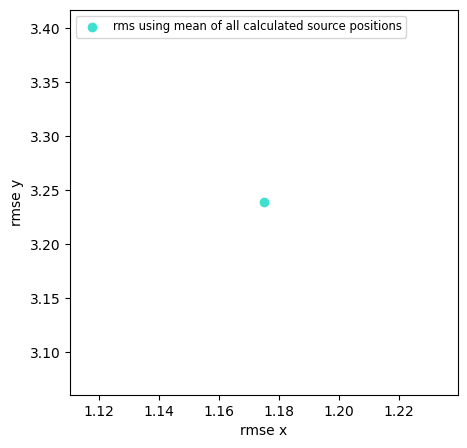

In [22]:
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

colors = ['mediumpurple', 'darkkhaki', 'aquamarine', 'paleturquoise', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dodgerblue', 'firebrick', 'khaki', 'forestgreen', 'fuchsia', 'gainsboro', 'crimson', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'chocolate', 'cornflowerblue', 'seagreen']

cutoff = 0
ax.scatter(func_rmse_x, func_rmse_y, c='turquoise', label='rms using mean of all calculated source positions')
ax.set_xlabel('rmse x')
ax.set_ylabel('rmse y')

plt.legend(loc='upper left', fontsize='small')
plt.show()

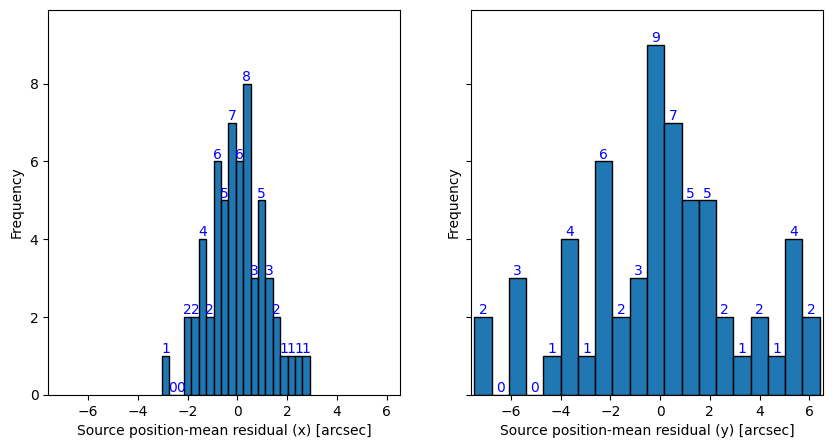

In [23]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

x_data = []
y_data = []

for i in range(len(func_diffs_x)):
    for j in range(len(func_diffs_x[i])):
        x_data.append(func_diffs_x[i][j])
        y_data.append(func_diffs_y[i][j])

values_x, bins_x, bars_x = ax[0].hist(x_data, bins=20, edgecolor='black')
values_y, bins_y, bars_y = ax[1].hist(y_data, bins=20, edgecolor='black')

ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')

ax[0].set_xlabel('Source position-mean residual (x) [arcsec]')
ax[1].set_xlabel('Source position-mean residual (y) [arcsec]')

ax[0].bar_label(bars_x, fontsize=10, color='blue')
ax[1].bar_label(bars_y, fontsize=10, color='blue')

ax[0].margins(x=0.01, y=0.1)
ax[1].margins(x=0.01, y=0.1)

ax[0].set_title('')
ax[1].set_title('')

plt.show()

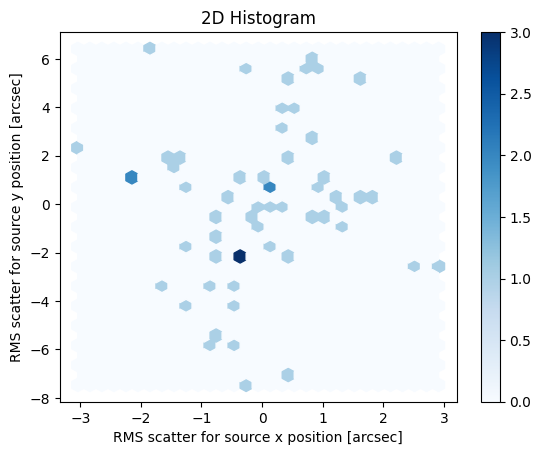

In [24]:
plt.hexbin(x_data, y_data, gridsize=30, cmap='Blues')
plt.xlabel('RMS scatter for source x position [arcsec]')
plt.ylabel('RMS scatter for source y position [arcsec]')
plt.title('2D Histogram')
plt.colorbar()

plt.show()

## Run the modeling - Particle Swarm Optimization to find a maxima in the likelihood

In [ ]:
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400, 'n_iterations': 800}]] #['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}]]
    # you can add additional fixed parameters in the line above if you want

start_time = time.time()
chain_list_pso = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATIONS, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


  0%|          | 0/800 [00:00<?, ?it/s]Traceback (most recent call last):
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\Samplers\pso.py", line 472, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 352, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\likelihood.py", line 428, in log_likelihood
    logL += self._position_likelihood.logL(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\users\earth\documents\graduate school\stony brook\research\lenstronomy\lenstronomy\Sampling\Likelihoods\position_likelihood.py", line 128, in logL
    logL_source_pos = self.sour

PSO: Exception while calling your likelihood function:
  params: [np.float64(0.8991732505423978)]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

: 

In [ ]:
fitting_seq.best_fit_likelihood(verbose=True)

In [ ]:
kwargs_result = fitting_seq.best_fit(bijective=True)
args_result = fitting_seq.param_class.kwargs2args(**kwargs_result)
logL = fitting_seq.likelihoodModule.logL(args_result, verbose=True)

from lenstronomy.Plots import chain_plot
for i in range(len(chain_list_pso)):
    chain_plot.plot_chain_list(chain_list_pso, i)

print("kwargs_results", kwargs_result)

## MCMC posterior sampling

In [ ]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC', {'n_burn': 400, 'n_run': 600, 'walkerRatio': 10,'sigma_scale': 0.1}]
]
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)

kwargs_result = fitting_seq.best_fit()

In [ ]:
## we want the logL (log likelihood) to stay fairly flat across the plot, that means its a decent guess.
chain_plot.plot_chain_list(chain_list_mcmc)

## Post-processing the chains 

In [ ]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_mcmc[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters
# this allows to recover the full parameters of all model components, not just the ones being sampled.

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_special=fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lensModel = LensModel(kwargs_model['lens_model_list'])
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
print("parameter values: ", param)

In [ ]:
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]

lenstronomy_clusters_functions.clusters_functions.real_image_pos_labels(num_sources_data, grouped_x_imgs, labels_new, label_lists, image_position_likelihood=False)
lenstronomy_clusters_functions.clusters_functions.flux_ratio_labels(num_sources_data, grouped_x_imgs, labels_new, label_lists, flux_ratio_likelihood=False)
lenstronomy_clusters_functions.clusters_functions.source_size_labels(kwargs_constraints, labels_new, special_params=special_params)
lenstronomy_clusters_functions.clusters_functions.time_delay_labels(labels_new, time_delay_likelihood=True)
    
print(labels_new)

In [ ]:
# mcmc_new_list = samples2posterior_plot(samples=samples_mcmc, mcmc_list=mcmc_new_list, param_class=param, kwargs_constraints=kwargs_constraints, with_flux_ratios=True)

new_chain = []
mcmc_new_list_cluster = []

mcmc_new_list_cluster = lenstronomy_clusters_functions.clusters_functions.samples2posterior_plot(samples=samples_mcmc, mcmc_list=mcmc_new_list_cluster, param_class=param, kwargs_constraints=kwargs_constraints, special_params=special_params, image_position_likelihood=False, with_flux_ratios=False, time_delay_likelihood=True)

In [ ]:
np.save('mcmc_new_list_cluster', mcmc_new_list_cluster)
print(mcmc_new_list_cluster[0])

In [ ]:
print(np.shape(mcmc_new_list_cluster))
print(len(labels_new))

In [ ]:
# import code for legend on corner plot
import matplotlib.lines as mlines

# purple_line = mlines.Line2D([], [], color='purple', label=str(num_sources_data)+" Sources, varied z")
blue_line = mlines.Line2D([], [], color='blue', label='Clusters, const z')

In [ ]:
# mcmc_new_list_cluster = np.load('mcmc_new_list_cluster.npy')
# mcmc_new_list_05 = np.load('mcmc_new_list_05.npy')
# samples5 = np.array(mcmc_new_list_05[87000:198000])
samples_cluster = np.array(mcmc_new_list_cluster[75000:150000])

figure = corner.corner(samples_cluster, labels=labels_new, color='blue', show_titles=True) # fig=plot should put the one with reduced data and the full one on top of each other... reduced = blue, original = gray
# figure = corner.corner(samples_variedz, labels=labels_new, color='blue', show_titles=False) 
# plot = corner.corner(samples_constz, fig=figure, labels=labels_new, color='purple', truth_color = 'orange', show_titles=True)
                    #  truths=[kwargs_lens[0]['theta_E'], gamma1, phi, q, 0.1, gamma2, lensCosmo.ddt], truth_color='orange', show_titles=True)
# theta_E = 1.0
# gamma = 2.0
# phi_lens = -0.7
# q = 0.9
# phi_ext = 0.1
# gamma_ext = 0.1
# Ddt = lensCosmo.ddt
#plot = corner.corner(samples8, fig=figure, labels=labels_new, color='purple', show_titles=False, truths=[theta_, gamma, phi_lens, q, phi_ext, gamma_ext, d_dt], truth_color='orange')


plt.legend(handles=[blue_line], bbox_to_anchor=(-2, 4., 1., .0), loc=1)


In [ ]:
# input truth time-delay distance [Mpc]
lensCosmo.ddt